## Histograms of Oriented Gradients for Human Detection: Project Report

Tien Trung Pham

Student ID: 24026638


In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
from glob import glob
import random
from skimage.feature import hog
#from skimage.transform import pyramid_gaussian
from skimage import color
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk


In [2]:
# Define constants
IMG_SIZE = (64, 128)  # (height, width) for training and feature extraction
DETECTION_SIZE = (64, 128)  # Larger size for detection
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
TRAIN_SIZE = 4000  # 2000 positive + 2000 negative
TEST_SIZE = 200    # 100 positive + 100 negative

# Define paths
pos_train_path = r".\Others\positive images\train"
pos_test_path = r".\Others\positive images\test"
neg_train_path = r".\Others\negative images\train"
neg_test_path = r".\Others\negative images\test"

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Load Image and preprocessing

In [3]:
# Function to load and preprocess images
def load_images(img_files, label, max_images, flip=False, target_size=IMG_SIZE, crop=True):
    images = []
    labels = []
    img_files = img_files[:max_images]
    for img_path in img_files:
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img, dtype=np.float32)
            original_shape = img.shape

            if label == 0 and crop:  # Negative images: keep bottom half only if crop is enabled
                height, width = img.shape
                crop_height = height // 2
                img = img[height - crop_height:, :]  # Deterministic bottom half crop
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            else:  # Positive images or no crop: resize without cropping
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

            if np.max(img) == 0:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    if label == 0 and crop:
                        height, width = img.shape
                        crop_height = height // 2
                        img = img[height - crop_height:, :]
                        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    else:
                        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                else:
                    print(f"Error: Failed to load {img_path} as fallback")
                    continue

            # Validate image size
            if img.shape != (target_size[1], target_size[0]):  # (height, width)
                raise ValueError(f"Image {img_path} resized to {img.shape}, expected ({target_size[1]}, {target_size[0]})")

            images.append(img)
            labels.append(label)

            if flip and label == 1 and len(images) < max_images:
                img_flipped = cv2.flip(img, 1)
                if img_flipped.shape != (target_size[1], target_size[0]):
                    raise ValueError(f"Flipped image {img_path} resized to {img_flipped.shape}, expected ({target_size[1]}, {target_size[0]})")
                images.append(img_flipped)
                labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

    if len(images) > max_images:
        images = images[:max_images]
        labels = labels[:max_images]

    print(f"Loaded {len(images)} images with label {label}")
    return images, labels

In [4]:
# Validate paths and check for overlap
if not os.path.exists(pos_train_path):
    raise FileNotFoundError(f"Positive train path {pos_train_path} does not exist")
pos_train_files = glob(os.path.join(pos_train_path, '*.[jJ][pP][gG]')) + glob(os.path.join(pos_train_path, '*.[pP][nN][gG]')) + \
                  glob(os.path.join(pos_train_path, '*.[jJ][pP][eE][gG]'))
pos_train_files = list({os.path.basename(f).lower(): f for f in pos_train_files}.values())
print(f"Found {len(pos_train_files)} unique positive training images")

if not os.path.exists(pos_test_path):
    raise FileNotFoundError(f"Positive test path {pos_test_path} does not exist")
pos_test_files = glob(os.path.join(pos_test_path, '*.[jJ][pP][gG]')) + glob(os.path.join(pos_test_path, '*.[pP][nN][gG]')) + \
                 glob(os.path.join(pos_test_path, '*.[jJ][pP][eE][gG]'))
pos_test_files = list({os.path.basename(f).lower(): f for f in pos_test_files}.values())
print(f"Found {len(pos_test_files)} unique positive testing images")

if not os.path.exists(neg_train_path):
    raise FileNotFoundError(f"Negative train path {neg_train_path} does not exist")
neg_train_files = glob(os.path.join(neg_train_path, '*.[jJ][pP][gG]')) + glob(os.path.join(neg_train_path, '*.[pP][nN][gG]')) + \
                  glob(os.path.join(neg_train_path, '*.[jJ][pP][eE][gG]'))
neg_train_files = list({os.path.basename(f).lower(): f for f in neg_train_files}.values())
print(f"Found {len(neg_train_files)} unique negative training images")

if not os.path.exists(neg_test_path):
    raise FileNotFoundError(f"Negative test path {neg_test_path} does not exist")
neg_test_files = glob(os.path.join(neg_test_path, '*.[jJ][pP][gG]')) + glob(os.path.join(neg_test_path, '*.[pP][nN][gG]')) + \
                 glob(os.path.join(neg_test_path, '*.[jJ][pP][eE][gG]'))
neg_test_files = list({os.path.basename(f).lower(): f for f in neg_test_files}.values())
print(f"Found {len(neg_test_files)} unique negative testing images")

# Check for overlap between train and test sets
train_files_set = set(os.path.basename(f).lower() for f in pos_train_files + neg_train_files)
test_files_set = set(os.path.basename(f).lower() for f in pos_test_files + neg_test_files)
overlap = train_files_set.intersection(test_files_set)
if overlap:
    print(f"Warning: Found {len(overlap)} overlapping files between train and test sets: {overlap}")
else:
    print("No overlap between train and test sets.")

# Ensure enough images
if len(pos_train_files) < 2000:
    raise ValueError(f"Only {len(pos_train_files)} positive training images found, need at least 2000")
if len(pos_test_files) < 100:
    raise ValueError(f"Only {len(pos_test_files)} positive testing images found, need at least 100")
if len(neg_train_files) < 2000:
    raise ValueError(f"Only {len(neg_train_files)} negative training images found, need at least 2000")
if len(neg_test_files) < 100:
    raise ValueError(f"Only {len(neg_test_files)} negative testing images found, need at least 100")

Found 5451 unique positive training images
Found 100 unique positive testing images
Found 6568 unique negative training images
Found 100 unique negative testing images
No overlap between train and test sets.


In [5]:
# Shuffle files
random.shuffle(pos_train_files)
random.shuffle(pos_test_files)
random.shuffle(neg_train_files)
random.shuffle(neg_test_files)

# Load training data
print("\nLoading training data...")
pos_train_imgs, pos_train_labels = load_images(pos_train_files, 1, 2000, flip=False, target_size=IMG_SIZE)  
neg_train_imgs, neg_train_labels = load_images(neg_train_files, 0, 2000, target_size=IMG_SIZE)
train_images = pos_train_imgs + neg_train_imgs
train_labels = pos_train_labels + neg_train_labels
print(f"Loaded {len(pos_train_imgs)} positive training images")
print(f"Loaded {len(neg_train_imgs)} negative training images")

# Load testing data
print("\nLoading testing data...")
pos_test_imgs, pos_test_labels = load_images(pos_test_files, 1, 100, flip=False, target_size=IMG_SIZE, crop=False)
neg_test_imgs, neg_test_labels = load_images(neg_test_files, 0, 100, flip=False, target_size=IMG_SIZE, crop=False)
test_images = pos_test_imgs + neg_test_imgs
test_labels = pos_test_labels + neg_test_labels
print(f"Loaded {len(pos_test_imgs)} positive testing images")
print(f"Loaded {len(neg_test_imgs)} negative testing images")

# Shuffle test data
combined = list(zip(test_images, test_labels))
random.shuffle(combined)
test_images, test_labels = zip(*combined)
test_images = list(test_images)
test_labels = np.array(test_labels)

# Validate labels
print("Training label distribution:", np.bincount(train_labels))
print("Testing label distribution:", np.bincount(test_labels))
if len(np.bincount(train_labels)) != 2 or np.bincount(train_labels)[0] != 2000 or np.bincount(train_labels)[1] != 2000:
    raise ValueError(f"Invalid training labels: Expected 2000 negative and 2000 positive, got {np.bincount(train_labels)}")
if len(np.bincount(test_labels)) != 2 or np.bincount(test_labels)[0] != 100 or np.bincount(test_labels)[1] != 100:
    raise ValueError(f"Invalid testing labels: Expected 100 negative and 100 positive, got {np.bincount(test_labels)}")

# Check sizes
if len(train_images) != TRAIN_SIZE:
    raise ValueError(f"Expected {TRAIN_SIZE} training images, got {len(train_images)}")
else:
    print(f"Loaded {len(train_images)} training images")
if len(test_images) != TEST_SIZE:
    raise ValueError(f"Expected {TEST_SIZE} testing images, got {len(test_images)}")
else:
    print(f"Loaded {len(test_images)} testing images")



Loading training data...
Loaded 2000 images with label 1
Loaded 2000 images with label 0
Loaded 2000 positive training images
Loaded 2000 negative training images

Loading testing data...
Loaded 100 images with label 1
Loaded 100 images with label 0
Loaded 100 positive testing images
Loaded 100 negative testing images
Training label distribution: [2000 2000]
Testing label distribution: [100 100]
Loaded 4000 training images
Loaded 200 testing images


In [6]:
# Extract HOG features for training
data = []
for img in tqdm(train_images, desc="Extracting HOG features for training"):
    fd = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    data.append(fd)

data = np.array(data)
labels = np.array(train_labels)

# Train SVM without cross-validation
scaler = StandardScaler()
trainData_scaled = scaler.fit_transform(data)
model = LinearSVC(max_iter=1000, C=0.0001)
model.fit(trainData_scaled, labels)
print("SVM model trained on full training data.")

# Save the model and scaler
joblib.dump(model, 'Others/hog_svm_model.npy')
joblib.dump(scaler, 'Others/hog_scaler.npy')
print("Model and scaler saved as 'hog_svm_model.npy' and 'hog_scaler.npy'")


Extracting HOG features for training: 100%|███████████████████████████████████████| 4000/4000 [00:32<00:00, 122.40it/s]


SVM model trained on full training data.
Model and scaler saved as 'hog_svm_model.npy' and 'hog_scaler.npy'


In [7]:
# Define sliding window function
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def detect_pedestrians(image, model, scaler, winW=64, winH=128, stepSize=10, threshold=0.2, orientations=9):
    detections = []
    hog_image = None
    
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    # Resize the entire image to match training size
    image_resized = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
    if image_resized.shape != (IMG_SIZE[1], IMG_SIZE[0]):  # (height, width)
        raise ValueError(f"Resized image has size {image_resized.shape}, expected ({IMG_SIZE[1]}, {IMG_SIZE[0]})")

    # Compute HOG visualization for the entire image
    _, hog_image = hog(image_resized, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                       cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
    hog_image = cv2.normalize(hog_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    total_windows = 0
    positive_predictions = 0
    high_confidence = 0

    # Apply sliding window on the resized image
    for (x, y, window) in sliding_window(image_resized, stepSize=stepSize, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        total_windows += 1
        
        window_resized = window
        if np.max(window_resized) == 0:
            print(f"Warning: Window at ({x}, {y}) is black")
            continue
        
        fds = hog(window_resized, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                  cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
        fds = fds.reshape(1, -1)
        fds_scaled = scaler.transform(fds)
        pred = model.predict(fds_scaled)
        score = model.decision_function(fds_scaled)[0]
        
        if pred == 1:
            positive_predictions += 1
            print(f"Positive prediction at ({x}, {y}), Score: {score:.4f}")
            detections.append((x, y, score, winW, winH))
            if score > threshold:
                high_confidence += 1
                print(f"Detection:: Location -> ({x}, {y}), Score -> {score:.4f}")

    print(f"Total windows checked: {total_windows}")
    if total_windows > 0:
        print(f"Positive predictions: {positive_predictions} ({positive_predictions/total_windows*100:.2f}%)")
        print(f"High confidence detections: {high_confidence} ({high_confidence/total_windows*100:.2f}%)")
    else:
        print("No valid windows found.")
    return detections, total_windows, positive_predictions, hog_image

In [8]:
# Load the model and scaler
model = joblib.load('Others/hog_svm_model.npy')
scaler = joblib.load('Others/hog_scaler.npy')

In [9]:
# Extract HOG features for test set and evaluate
test_data = []
for img in tqdm(test_images, desc="Extracting HOG features for test set"):
    img_resized = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
    fd = hog(img_resized, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    test_data.append(fd)

test_data_scaled = scaler.transform(np.array(test_data))
test_predictions = model.predict(test_data_scaled)


Extracting HOG features for test set: 100%|█████████████████████████████████████████| 200/200 [00:01<00:00, 105.51it/s]


In [10]:
# Evaluate
print("Classification Report on Test Set:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix:\n", confusion_matrix(test_labels, test_predictions))
accuracy = np.mean(test_predictions == test_labels)
print(f"Accuracy on test set: {accuracy:.4f}")

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       100
           1       0.88      0.86      0.87       100

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200

Confusion Matrix:
 [[88 12]
 [14 86]]
Accuracy on test set: 0.8700


In [11]:
# Compute DET curve points
def compute_fppw(y_true, y_pred, total_windows):
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    return false_positives / total_windows if total_windows > 0 else 0

def compute_miss_rate(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    return 1 - recall

Computing DET data:   0%|▎                                                             | 1/200 [00:00<00:22,  8.97it/s]

Positive prediction at (0, 0), Score: 0.9074
Detection:: Location -> (0, 0), Score -> 0.9074
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:   2%|▉                                                             | 3/200 [00:00<00:18, 10.44it/s]

Positive prediction at (0, 0), Score: 1.2786
Detection:: Location -> (0, 0), Score -> 1.2786
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:   2%|█▌                                                            | 5/200 [00:00<00:18, 10.55it/s]

Positive prediction at (0, 0), Score: 0.7020
Detection:: Location -> (0, 0), Score -> 0.7020
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0734
Detection:: Location -> (0, 0), Score -> 1.0734
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:   4%|██▍                                                           | 8/200 [00:00<00:21,  9.09it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:   5%|███                                                          | 10/200 [00:01<00:22,  8.46it/s]

Positive prediction at (0, 0), Score: 2.3964
Detection:: Location -> (0, 0), Score -> 2.3964
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:   6%|███▋                                                         | 12/200 [00:01<00:22,  8.38it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.3436
Detection:: Location -> (0, 0), Score -> 0.3436
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:   7%|████▎                                                        | 14/200 [00:01<00:23,  7.92it/s]

Positive prediction at (0, 0), Score: 1.4694
Detection:: Location -> (0, 0), Score -> 1.4694
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:   8%|████▉                                                        | 16/200 [00:01<00:22,  8.26it/s]

Positive prediction at (0, 0), Score: 1.5400
Detection:: Location -> (0, 0), Score -> 1.5400
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1910
Detection:: Location -> (0, 0), Score -> 1.1910
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:   9%|█████▍                                                       | 18/200 [00:02<00:22,  7.92it/s]

Positive prediction at (0, 0), Score: 0.4113
Detection:: Location -> (0, 0), Score -> 0.4113
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9059
Detection:: Location -> (0, 0), Score -> 1.9059
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  10%|██████                                                       | 20/200 [00:02<00:23,  7.53it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.1210
Detection:: Location -> (0, 0), Score -> 2.1210
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  11%|██████▋                                                      | 22/200 [00:02<00:25,  7.04it/s]

Positive prediction at (0, 0), Score: 1.5006
Detection:: Location -> (0, 0), Score -> 1.5006
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.2613
Detection:: Location -> (0, 0), Score -> 2.2613
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  12%|███████▎                                                     | 24/200 [00:02<00:22,  7.74it/s]

Positive prediction at (0, 0), Score: 2.7692
Detection:: Location -> (0, 0), Score -> 2.7692
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1877
Detection:: Location -> (0, 0), Score -> 1.1877
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  13%|███████▉                                                     | 26/200 [00:03<00:23,  7.33it/s]

Positive prediction at (0, 0), Score: 0.5216
Detection:: Location -> (0, 0), Score -> 0.5216
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8597
Detection:: Location -> (0, 0), Score -> 0.8597
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  14%|████████▌                                                    | 28/200 [00:03<00:24,  7.17it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.2683
Detection:: Location -> (0, 0), Score -> 0.2683
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  15%|█████████▏                                                   | 30/200 [00:03<00:21,  7.80it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  16%|█████████▊                                                   | 32/200 [00:03<00:21,  7.73it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  17%|██████████▎                                                  | 34/200 [00:04<00:20,  8.01it/s]

Positive prediction at (0, 0), Score: 1.0308
Detection:: Location -> (0, 0), Score -> 1.0308
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7993
Detection:: Location -> (0, 0), Score -> 0.7993
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  18%|███████████▎                                                 | 37/200 [00:04<00:18,  8.81it/s]

Positive prediction at (0, 0), Score: 1.0835
Detection:: Location -> (0, 0), Score -> 1.0835
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3418
Detection:: Location -> (0, 0), Score -> 1.3418
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9737
Detection:: Location -> (0, 0), Score -> 1.9737
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  20%|███████████▉                                                 | 39/200 [00:04<00:18,  8.65it/s]

Positive prediction at (0, 0), Score: 0.1792
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  20%|████████████▌                                                | 41/200 [00:05<00:18,  8.45it/s]

Positive prediction at (0, 0), Score: 1.3966
Detection:: Location -> (0, 0), Score -> 1.3966
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1200
Detection:: Location -> (0, 0), Score -> 2.1200
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  22%|█████████████                                                | 43/200 [00:05<00:19,  8.22it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7809
Detection:: Location -> (0, 0), Score -> 1.7809
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  22%|█████████████▋                                               | 45/200 [00:05<00:18,  8.17it/s]

Positive prediction at (0, 0), Score: 2.9202
Detection:: Location -> (0, 0), Score -> 2.9202
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8243
Detection:: Location -> (0, 0), Score -> 1.8243
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  24%|██████████████▎                                              | 47/200 [00:05<00:19,  7.99it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.2057
Detection:: Location -> (0, 0), Score -> 0.2057
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  24%|██████████████▉                                              | 49/200 [00:06<00:19,  7.75it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  26%|███████████████▌                                             | 51/200 [00:06<00:18,  7.86it/s]

Positive prediction at (0, 0), Score: 1.6999
Detection:: Location -> (0, 0), Score -> 1.6999
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2917
Detection:: Location -> (0, 0), Score -> 1.2917
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  26%|████████████████▏                                            | 53/200 [00:06<00:17,  8.61it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  28%|████████████████▊                                            | 55/200 [00:06<00:19,  7.51it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0358
Detection:: Location -> (0, 0), Score -> 1.0358
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  28%|█████████████████▍                                           | 57/200 [00:07<00:18,  7.61it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.3664
Detection:: Location -> (0, 0), Score -> 0.3664
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  30%|█████████████████▉                                           | 59/200 [00:07<00:20,  6.84it/s]

Positive prediction at (0, 0), Score: 1.1096
Detection:: Location -> (0, 0), Score -> 1.1096
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  30%|██████████████████▌                                          | 61/200 [00:07<00:22,  6.14it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  32%|███████████████████▏                                         | 63/200 [00:08<00:22,  6.18it/s]

Positive prediction at (0, 0), Score: 1.1591
Detection:: Location -> (0, 0), Score -> 1.1591
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  32%|███████████████████▊                                         | 65/200 [00:08<00:22,  5.97it/s]

Positive prediction at (0, 0), Score: 1.6627
Detection:: Location -> (0, 0), Score -> 1.6627
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1009
Detection:: Location -> (0, 0), Score -> 2.1009
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  34%|████████████████████▍                                        | 67/200 [00:08<00:23,  5.72it/s]

Positive prediction at (0, 0), Score: 2.0845
Detection:: Location -> (0, 0), Score -> 2.0845
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  34%|█████████████████████                                        | 69/200 [00:09<00:21,  5.99it/s]

Positive prediction at (0, 0), Score: 1.3835
Detection:: Location -> (0, 0), Score -> 1.3835
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  36%|█████████████████████▋                                       | 71/200 [00:09<00:20,  6.40it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  36%|██████████████████████▎                                      | 73/200 [00:09<00:18,  6.87it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7709
Detection:: Location -> (0, 0), Score -> 1.7709
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  38%|██████████████████████▉                                      | 75/200 [00:09<00:17,  7.15it/s]

Positive prediction at (0, 0), Score: 1.8711
Detection:: Location -> (0, 0), Score -> 1.8711
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0044
Detection:: Location -> (0, 0), Score -> 1.0044
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  38%|███████████████████████▍                                     | 77/200 [00:10<00:17,  7.09it/s]

Positive prediction at (0, 0), Score: 0.6379
Detection:: Location -> (0, 0), Score -> 0.6379
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  40%|████████████████████████                                     | 79/200 [00:10<00:17,  7.09it/s]

Positive prediction at (0, 0), Score: 1.5423
Detection:: Location -> (0, 0), Score -> 1.5423
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3269
Detection:: Location -> (0, 0), Score -> 1.3269
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  40%|████████████████████████▋                                    | 81/200 [00:10<00:15,  7.71it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4073
Detection:: Location -> (0, 0), Score -> 1.4073
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  42%|█████████████████████████▎                                   | 83/200 [00:11<00:16,  6.96it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8641
Detection:: Location -> (0, 0), Score -> 1.8641
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  42%|█████████████████████████▉                                   | 85/200 [00:11<00:17,  6.68it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  44%|██████████████████████████▊                                  | 88/200 [00:11<00:14,  8.00it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  46%|███████████████████████████▊                                 | 91/200 [00:12<00:12,  9.00it/s]

Positive prediction at (0, 0), Score: 2.1158
Detection:: Location -> (0, 0), Score -> 2.1158
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1515
Detection:: Location -> (0, 0), Score -> 1.1515
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  46%|████████████████████████████▎                                | 93/200 [00:12<00:11,  9.21it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  48%|████████████████████████████▉                                | 95/200 [00:12<00:13,  7.99it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7406
Detection:: Location -> (0, 0), Score -> 1.7406
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  48%|█████████████████████████████▌                               | 97/200 [00:12<00:13,  7.57it/s]

Positive prediction at (0, 0), Score: 1.3604
Detection:: Location -> (0, 0), Score -> 1.3604
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6338
Detection:: Location -> (0, 0), Score -> 0.6338
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  50%|██████████████████████████████▏                              | 99/200 [00:13<00:13,  7.73it/s]

Positive prediction at (0, 0), Score: 1.5955
Detection:: Location -> (0, 0), Score -> 1.5955
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7815
Detection:: Location -> (0, 0), Score -> 1.7815
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  50%|██████████████████████████████▎                             | 101/200 [00:13<00:12,  7.66it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  52%|██████████████████████████████▉                             | 103/200 [00:13<00:12,  7.62it/s]

Positive prediction at (0, 0), Score: 0.0602
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6091
Detection:: Location -> (0, 0), Score -> 1.6091
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  52%|███████████████████████████████▌                            | 105/200 [00:13<00:12,  7.43it/s]

Positive prediction at (0, 0), Score: 1.6355
Detection:: Location -> (0, 0), Score -> 1.6355
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  54%|████████████████████████████████                            | 107/200 [00:14<00:13,  6.88it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  55%|████████████████████████████████▋                           | 109/200 [00:14<00:13,  6.59it/s]

Positive prediction at (0, 0), Score: 1.3419
Detection:: Location -> (0, 0), Score -> 1.3419
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2893
Detection:: Location -> (0, 0), Score -> 1.2893
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  56%|█████████████████████████████████▎                          | 111/200 [00:14<00:14,  6.25it/s]

Positive prediction at (0, 0), Score: 1.8308
Detection:: Location -> (0, 0), Score -> 1.8308
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3949
Detection:: Location -> (0, 0), Score -> 0.3949
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  56%|█████████████████████████████████▉                          | 113/200 [00:15<00:14,  6.12it/s]

Positive prediction at (0, 0), Score: 1.8143
Detection:: Location -> (0, 0), Score -> 1.8143
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  57%|██████████████████████████████████▌                         | 115/200 [00:15<00:13,  6.36it/s]

Positive prediction at (0, 0), Score: 1.0353
Detection:: Location -> (0, 0), Score -> 1.0353
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6630
Detection:: Location -> (0, 0), Score -> 0.6630
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  58%|███████████████████████████████████                         | 117/200 [00:15<00:14,  5.57it/s]

Positive prediction at (0, 0), Score: 1.0415
Detection:: Location -> (0, 0), Score -> 1.0415
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3277
Detection:: Location -> (0, 0), Score -> 1.3277
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  59%|███████████████████████████████████▍                        | 118/200 [00:16<00:15,  5.23it/s]

Positive prediction at (0, 0), Score: 0.3422
Detection:: Location -> (0, 0), Score -> 0.3422
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  60%|████████████████████████████████████                        | 120/200 [00:16<00:16,  4.81it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  61%|████████████████████████████████████▌                       | 122/200 [00:16<00:15,  5.17it/s]

Positive prediction at (0, 0), Score: 1.0011
Detection:: Location -> (0, 0), Score -> 1.0011
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  62%|█████████████████████████████████████▏                      | 124/200 [00:17<00:14,  5.39it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  62%|█████████████████████████████████████▌                      | 125/200 [00:17<00:14,  5.30it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  64%|██████████████████████████████████████                      | 127/200 [00:17<00:13,  5.34it/s]

Positive prediction at (0, 0), Score: 0.0168
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4280
Detection:: Location -> (0, 0), Score -> 1.4280
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  64%|██████████████████████████████████████▋                     | 129/200 [00:18<00:12,  5.52it/s]

Positive prediction at (0, 0), Score: 0.0853
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  66%|███████████████████████████████████████▎                    | 131/200 [00:18<00:10,  6.41it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8418
Detection:: Location -> (0, 0), Score -> 1.8418
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  66%|███████████████████████████████████████▉                    | 133/200 [00:18<00:09,  7.42it/s]

Positive prediction at (0, 0), Score: 2.1512
Detection:: Location -> (0, 0), Score -> 2.1512
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  68%|████████████████████████████████████████▌                   | 135/200 [00:18<00:08,  7.65it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1948
Detection:: Location -> (0, 0), Score -> 1.1948
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  68%|█████████████████████████████████████████                   | 137/200 [00:19<00:08,  7.38it/s]

Positive prediction at (0, 0), Score: 1.9926
Detection:: Location -> (0, 0), Score -> 1.9926
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  70%|█████████████████████████████████████████▋                  | 139/200 [00:19<00:08,  7.30it/s]

Positive prediction at (0, 0), Score: 1.9628
Detection:: Location -> (0, 0), Score -> 1.9628
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  70%|██████████████████████████████████████████▎                 | 141/200 [00:19<00:07,  7.56it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 3.0795
Detection:: Location -> (0, 0), Score -> 3.0795
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  72%|██████████████████████████████████████████▉                 | 143/200 [00:19<00:06,  8.60it/s]

Positive prediction at (0, 0), Score: 0.9718
Detection:: Location -> (0, 0), Score -> 0.9718
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1255
Detection:: Location -> (0, 0), Score -> 1.1255
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  73%|███████████████████████████████████████████▊                | 146/200 [00:20<00:06,  8.85it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  74%|████████████████████████████████████████████▍               | 148/200 [00:20<00:05,  9.21it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  75%|█████████████████████████████████████████████               | 150/200 [00:20<00:05,  9.21it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  76%|█████████████████████████████████████████████▌              | 152/200 [00:20<00:05,  8.66it/s]

Positive prediction at (0, 0), Score: 0.7259
Detection:: Location -> (0, 0), Score -> 0.7259
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  77%|██████████████████████████████████████████████▏             | 154/200 [00:21<00:06,  7.54it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7341
Detection:: Location -> (0, 0), Score -> 1.7341
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  78%|██████████████████████████████████████████████▊             | 156/200 [00:21<00:06,  7.25it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2155
Detection:: Location -> (0, 0), Score -> 1.2155
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  80%|███████████████████████████████████████████████▋            | 159/200 [00:21<00:05,  8.11it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  80%|████████████████████████████████████████████████▎           | 161/200 [00:22<00:04,  8.18it/s]

Positive prediction at (0, 0), Score: 1.4017
Detection:: Location -> (0, 0), Score -> 1.4017
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  82%|████████████████████████████████████████████████▉           | 163/200 [00:22<00:04,  8.33it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4335
Detection:: Location -> (0, 0), Score -> 1.4335
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  82%|█████████████████████████████████████████████████▌          | 165/200 [00:22<00:04,  7.84it/s]

Positive prediction at (0, 0), Score: 1.6227
Detection:: Location -> (0, 0), Score -> 1.6227
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  84%|██████████████████████████████████████████████████          | 167/200 [00:22<00:04,  7.58it/s]

Positive prediction at (0, 0), Score: 1.0254
Detection:: Location -> (0, 0), Score -> 1.0254
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  84%|██████████████████████████████████████████████████▋         | 169/200 [00:23<00:04,  7.28it/s]

Positive prediction at (0, 0), Score: 0.8421
Detection:: Location -> (0, 0), Score -> 0.8421
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  86%|███████████████████████████████████████████████████▎        | 171/200 [00:23<00:03,  7.52it/s]

Positive prediction at (0, 0), Score: 1.4436
Detection:: Location -> (0, 0), Score -> 1.4436
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4854
Detection:: Location -> (0, 0), Score -> 1.4854
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  86%|███████████████████████████████████████████████████▉        | 173/200 [00:23<00:03,  7.58it/s]

Positive prediction at (0, 0), Score: 1.4113
Detection:: Location -> (0, 0), Score -> 1.4113
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  88%|████████████████████████████████████████████████████▌       | 175/200 [00:23<00:03,  8.00it/s]

Positive prediction at (0, 0), Score: 1.6303
Detection:: Location -> (0, 0), Score -> 1.6303
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9785
Detection:: Location -> (0, 0), Score -> 0.9785
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  88%|█████████████████████████████████████████████████████       | 177/200 [00:24<00:03,  7.17it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  90%|█████████████████████████████████████████████████████▋      | 179/200 [00:24<00:03,  6.42it/s]

Positive prediction at (0, 0), Score: 2.0334
Detection:: Location -> (0, 0), Score -> 2.0334
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3976
Detection:: Location -> (0, 0), Score -> 1.3976
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  90%|██████████████████████████████████████████████████████▎     | 181/200 [00:24<00:03,  6.20it/s]

Positive prediction at (0, 0), Score: 0.8923
Detection:: Location -> (0, 0), Score -> 0.8923
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3887
Detection:: Location -> (0, 0), Score -> 1.3887
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  92%|██████████████████████████████████████████████████████▉     | 183/200 [00:25<00:02,  6.13it/s]

Positive prediction at (0, 0), Score: 1.4896
Detection:: Location -> (0, 0), Score -> 1.4896
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3408
Detection:: Location -> (0, 0), Score -> 0.3408
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  92%|███████████████████████████████████████████████████████▌    | 185/200 [00:25<00:02,  5.85it/s]

Positive prediction at (0, 0), Score: 1.6939
Detection:: Location -> (0, 0), Score -> 1.6939
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.3062
Detection:: Location -> (0, 0), Score -> 2.3062
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  94%|████████████████████████████████████████████████████████    | 187/200 [00:25<00:01,  6.58it/s]

Positive prediction at (0, 0), Score: 0.9416
Detection:: Location -> (0, 0), Score -> 0.9416
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3310
Detection:: Location -> (0, 0), Score -> 1.3310
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  94%|████████████████████████████████████████████████████████▋   | 189/200 [00:26<00:01,  6.36it/s]

Positive prediction at (0, 0), Score: 1.9126
Detection:: Location -> (0, 0), Score -> 1.9126
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6860
Detection:: Location -> (0, 0), Score -> 0.6860
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  96%|█████████████████████████████████████████████████████████▎  | 191/200 [00:26<00:01,  6.00it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data:  96%|█████████████████████████████████████████████████████████▉  | 193/200 [00:26<00:01,  6.45it/s]

Positive prediction at (0, 0), Score: 0.3955
Detection:: Location -> (0, 0), Score -> 0.3955
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1015
Detection:: Location -> (0, 0), Score -> 1.1015
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  98%|██████████████████████████████████████████████████████████▌ | 195/200 [00:27<00:00,  6.38it/s]

Positive prediction at (0, 0), Score: 0.8218
Detection:: Location -> (0, 0), Score -> 0.8218
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7726
Detection:: Location -> (0, 0), Score -> 1.7726
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data:  98%|███████████████████████████████████████████████████████████ | 197/200 [00:27<00:00,  6.11it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data: 100%|███████████████████████████████████████████████████████████▋| 199/200 [00:27<00:00,  6.03it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.3567
Detection:: Location -> (0, 0), Score -> 2.3567
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data: 100%|████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.15it/s]


Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


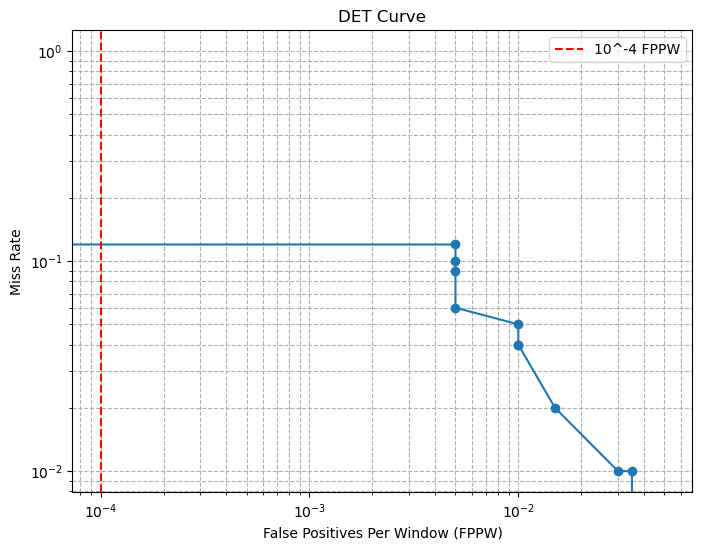

In [12]:
#Collect scores and predictions for DET curve
all_scores = []
all_labels = []
total_windows_sum = 0
for i in tqdm(range(len(test_images)), desc="Computing DET data"):
    img = test_images[i]
    true_label = test_labels[i]
    detections, total_windows, positive_predictions, _ = detect_pedestrians(img, model, scaler, threshold=0.2)
    total_windows_sum += total_windows
    for _, _, score, _, _ in detections:
        all_scores.append(score)
        all_labels.append(true_label)

all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

# Compute DET curve
thresholds = np.linspace(min(all_scores) if all_scores.size > 0 else -2, max(all_scores) if all_scores.size > 0 else 2, 50)
miss_rates = []
fppws = []
for thresh in thresholds:
    y_pred = (all_scores > thresh).astype(int)
    miss_rates.append(compute_miss_rate(all_labels, y_pred))
    fppws.append(compute_fppw(all_labels, y_pred, total_windows_sum))

# Plot DET curve
plt.figure(figsize=(8, 6))
plt.loglog(fppws, miss_rates, marker='o')
plt.xlabel('False Positives Per Window (FPPW)')
plt.ylabel('Miss Rate')
plt.title('DET Curve')
plt.grid(True, which="both", ls="--")
plt.axvline(x=1e-4, color='r', linestyle='--', label='10^-4 FPPW')
plt.legend()
plt.savefig('Others/det_curve.png')
plt.show()

## Test and plot the HOG on some testing images in the test dataset

In [ ]:
# Test on a subset of test images with visualization
num_test_images = 10
random_indices = random.sample(range(len(test_images)), min(num_test_images, len(test_images)))
for i in random_indices:
    img = test_images[i]
    true_label = test_labels[i]
    print(f"\nTest Image {i+1} - Original min/max pixel values: {np.min(img)}/{np.max(img)}")
    
    # Detect pedestrians and get HOG visualization
    detections, total_windows, positive_predictions, hog_image = detect_pedestrians(img, model, scaler, threshold=0.2)
    
    # Apply non-maximum suppression
    rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) if detections else np.array([])
    scores = np.array([score for (_, _, score, _, _) in detections]) if detections else np.array([])
    pick = non_max_suppression(rects, probs=scores, overlapThresh=0.3) if len(rects) > 0 else []
    
    print(f"Number of detections before NMS: {len(detections)}")
    print(f"Number of detections after NMS: {len(pick)}")
    
    # Prepare original image for visualization
    img_display = img.copy()
    if np.max(img_display) > np.min(img_display):
        img_display = (img_display - np.min(img_display)) / (np.max(img_display) - np.min(img_display)) * 255
    img_display = img_display.astype(np.uint8)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)

    # Draw rectangles on detected image
    detected_img = img_display.copy()
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(detected_img, (xA, yA), (xB, yB), (0, 255, 0), 2)

    # Create a figure with three subplots side by side
    plt.figure(figsize=(18, 6))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_display, cmap='gray')
    plt.title(f"Original Image {i+1}\nTrue Label: {true_label}")
    plt.axis('off')
    
    # Detected Image
    plt.subplot(1, 3, 2)
    plt.imshow(detected_img)
    plt.title(f"Detected Image {i+1}\nDetections: {len(pick)}")
    plt.axis('off')
    
    # HOG Visualization
    plt.subplot(1, 3, 3)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"HOG Visualization {i+1}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Ablation study


Training and evaluating with 9 bins (0°-180°)...


Extracting HOG features for training (9 bins (0°-180°)): 100%|████████████████████| 4000/4000 [00:33<00:00, 118.73it/s]


SVM model trained for 9 bins (0°-180°).


Computing DET data (9 bins (0°-180°)):   0%|                                                   | 0/200 [00:00<?, ?it/s]

Positive prediction at (0, 0), Score: 0.9074
Detection:: Location -> (0, 0), Score -> 0.9074
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   1%|▍                                          | 2/200 [00:00<00:19, 10.11it/s]

Positive prediction at (0, 0), Score: 1.2786
Detection:: Location -> (0, 0), Score -> 1.2786
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):   2%|▊                                          | 4/200 [00:00<00:17, 11.02it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7020
Detection:: Location -> (0, 0), Score -> 0.7020
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   3%|█▎                                         | 6/200 [00:00<00:18, 10.22it/s]

Positive prediction at (0, 0), Score: 1.0734
Detection:: Location -> (0, 0), Score -> 1.0734
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   4%|█▋                                         | 8/200 [00:00<00:18, 10.28it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):   5%|██                                        | 10/200 [00:00<00:15, 12.07it/s]

Positive prediction at (0, 0), Score: 2.3964
Detection:: Location -> (0, 0), Score -> 2.3964
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):   6%|██▌                                       | 12/200 [00:01<00:14, 13.10it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.3436
Detection:: Location -> (0, 0), Score -> 0.3436
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4694
Detection:: Location -> (0, 0), Score -> 1.4694
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   7%|██▉                                       | 14/200 [00:01<00:14, 12.42it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5400
Detection:: Location -> (0, 0), Score -> 1.5400
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   8%|███▎                                      | 16/200 [00:01<00:14, 12.50it/s]

Positive prediction at (0, 0), Score: 1.1910
Detection:: Location -> (0, 0), Score -> 1.1910
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.4113
Detection:: Location -> (0, 0), Score -> 0.4113
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):   9%|███▊                                      | 18/200 [00:01<00:16, 10.93it/s]

Positive prediction at (0, 0), Score: 1.9059
Detection:: Location -> (0, 0), Score -> 1.9059
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  10%|████▏                                     | 20/200 [00:01<00:16, 11.01it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.1210
Detection:: Location -> (0, 0), Score -> 2.1210
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5006
Detection:: Location -> (0, 0), Score -> 1.5006
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  11%|████▌                                     | 22/200 [00:01<00:17, 10.38it/s]

Positive prediction at (0, 0), Score: 2.2613
Detection:: Location -> (0, 0), Score -> 2.2613
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.7692
Detection:: Location -> (0, 0), Score -> 2.7692
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  12%|█████                                     | 24/200 [00:02<00:16, 10.46it/s]

Positive prediction at (0, 0), Score: 1.1877
Detection:: Location -> (0, 0), Score -> 1.1877
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  13%|█████▍                                    | 26/200 [00:02<00:15, 10.90it/s]

Positive prediction at (0, 0), Score: 0.5216
Detection:: Location -> (0, 0), Score -> 0.5216
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8597
Detection:: Location -> (0, 0), Score -> 0.8597
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  14%|█████▉                                    | 28/200 [00:02<00:16, 10.69it/s]

Positive prediction at (0, 0), Score: 0.2683
Detection:: Location -> (0, 0), Score -> 0.2683
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  16%|██████▌                                   | 31/200 [00:02<00:18,  8.98it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  17%|███████▏                                  | 34/200 [00:03<00:18,  9.04it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0308
Detection:: Location -> (0, 0), Score -> 1.0308
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7993
Detection:: Location -> (0, 0), Score -> 0.7993
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  18%|███████▊                                  | 37/200 [00:03<00:15, 10.31it/s]

Positive prediction at (0, 0), Score: 1.0835
Detection:: Location -> (0, 0), Score -> 1.0835
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3418
Detection:: Location -> (0, 0), Score -> 1.3418
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9737
Detection:: Location -> (0, 0), Score -> 1.9737
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  20%|████████▌                                 | 41/200 [00:03<00:12, 12.84it/s]

Positive prediction at (0, 0), Score: 0.1792
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3966
Detection:: Location -> (0, 0), Score -> 1.3966
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1200
Detection:: Location -> (0, 0), Score -> 2.1200
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  22%|█████████                                 | 43/200 [00:03<00:11, 13.30it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7809
Detection:: Location -> (0, 0), Score -> 1.7809
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.9202
Detection:: Location -> (0, 0), Score -> 2.9202
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  24%|██████████                                | 48/200 [00:04<00:10, 15.05it/s]

Positive prediction at (0, 0), Score: 1.8243
Detection:: Location -> (0, 0), Score -> 1.8243
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.2057
Detection:: Location -> (0, 0), Score -> 0.2057
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  26%|██████████▉                               | 52/200 [00:04<00:10, 14.45it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6999
Detection:: Location -> (0, 0), Score -> 1.6999
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2917
Detection:: Location -> (0, 0), Score -> 1.2917
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  27%|███████████▎                              | 54/200 [00:04<00:12, 11.92it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  28%|███████████▊                              | 56/200 [00:04<00:12, 11.34it/s]

Positive prediction at (0, 0), Score: 1.0358
Detection:: Location -> (0, 0), Score -> 1.0358
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.3664
Detection:: Location -> (0, 0), Score -> 0.3664
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  30%|████████████▌                             | 60/200 [00:05<00:11, 12.40it/s]

Positive prediction at (0, 0), Score: 1.1096
Detection:: Location -> (0, 0), Score -> 1.1096
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  32%|█████████████▍                            | 64/200 [00:05<00:11, 12.13it/s]

Positive prediction at (0, 0), Score: 1.1591
Detection:: Location -> (0, 0), Score -> 1.1591
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6627
Detection:: Location -> (0, 0), Score -> 1.6627
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  33%|█████████████▊                            | 66/200 [00:05<00:11, 11.85it/s]

Positive prediction at (0, 0), Score: 2.1009
Detection:: Location -> (0, 0), Score -> 2.1009
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0845
Detection:: Location -> (0, 0), Score -> 2.0845
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  35%|██████████████▋                           | 70/200 [00:06<00:11, 11.35it/s]

Positive prediction at (0, 0), Score: 1.3835
Detection:: Location -> (0, 0), Score -> 1.3835
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  36%|███████████████                           | 72/200 [00:06<00:12, 10.21it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7709
Detection:: Location -> (0, 0), Score -> 1.7709
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  38%|███████████████▉                          | 76/200 [00:06<00:10, 11.74it/s]

Positive prediction at (0, 0), Score: 1.8711
Detection:: Location -> (0, 0), Score -> 1.8711
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0044
Detection:: Location -> (0, 0), Score -> 1.0044
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6379
Detection:: Location -> (0, 0), Score -> 0.6379
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  40%|████████████████▊                         | 80/200 [00:06<00:09, 12.44it/s]

Positive prediction at (0, 0), Score: 1.5423
Detection:: Location -> (0, 0), Score -> 1.5423
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3269
Detection:: Location -> (0, 0), Score -> 1.3269
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  42%|█████████████████▋                        | 84/200 [00:07<00:08, 12.96it/s]

Positive prediction at (0, 0), Score: 1.4073
Detection:: Location -> (0, 0), Score -> 1.4073
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8641
Detection:: Location -> (0, 0), Score -> 1.8641
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  43%|██████████████████                        | 86/200 [00:07<00:10, 10.99it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  44%|██████████████████▍                       | 88/200 [00:07<00:11,  9.74it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  45%|██████████████████▉                       | 90/200 [00:08<00:11,  9.60it/s]

Positive prediction at (0, 0), Score: 2.1158
Detection:: Location -> (0, 0), Score -> 2.1158
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  46%|███████████████████▎                      | 92/200 [00:08<00:12,  8.73it/s]

Positive prediction at (0, 0), Score: 1.1515
Detection:: Location -> (0, 0), Score -> 1.1515
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  47%|███████████████████▋                      | 94/200 [00:08<00:11,  8.86it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7406
Detection:: Location -> (0, 0), Score -> 1.7406
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  48%|████████████████████▏                     | 96/200 [00:08<00:10, 10.17it/s]

Positive prediction at (0, 0), Score: 1.3604
Detection:: Location -> (0, 0), Score -> 1.3604
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6338
Detection:: Location -> (0, 0), Score -> 0.6338
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  50%|████████████████████▊                     | 99/200 [00:09<00:11,  9.03it/s]

Positive prediction at (0, 0), Score: 1.5955
Detection:: Location -> (0, 0), Score -> 1.5955
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7815
Detection:: Location -> (0, 0), Score -> 1.7815
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  50%|████████████████████▋                    | 101/200 [00:09<00:11,  8.49it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  52%|█████████████████████                    | 103/200 [00:09<00:12,  7.97it/s]

Positive prediction at (0, 0), Score: 0.0602
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6091
Detection:: Location -> (0, 0), Score -> 1.6091
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6355
Detection:: Location -> (0, 0), Score -> 1.6355
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  54%|█████████████████████▉                   | 107/200 [00:09<00:08, 10.49it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  55%|██████████████████████▎                  | 109/200 [00:10<00:08, 10.83it/s]

Positive prediction at (0, 0), Score: 1.3419
Detection:: Location -> (0, 0), Score -> 1.3419
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2893
Detection:: Location -> (0, 0), Score -> 1.2893
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8308
Detection:: Location -> (0, 0), Score -> 1.8308
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  56%|███████████████████████▏                 | 113/200 [00:10<00:07, 12.31it/s]

Positive prediction at (0, 0), Score: 0.3949
Detection:: Location -> (0, 0), Score -> 0.3949
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8143
Detection:: Location -> (0, 0), Score -> 1.8143
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  57%|███████████████████████▌                 | 115/200 [00:10<00:06, 12.22it/s]

Positive prediction at (0, 0), Score: 1.0353
Detection:: Location -> (0, 0), Score -> 1.0353
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6630
Detection:: Location -> (0, 0), Score -> 0.6630
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0415
Detection:: Location -> (0, 0), Score -> 1.0415
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  60%|████████████████████████▍                | 119/200 [00:10<00:06, 11.84it/s]

Positive prediction at (0, 0), Score: 1.3277
Detection:: Location -> (0, 0), Score -> 1.3277
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3422
Detection:: Location -> (0, 0), Score -> 0.3422
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  62%|█████████████████████████▏               | 123/200 [00:11<00:05, 13.06it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0011
Detection:: Location -> (0, 0), Score -> 1.0011
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  62%|█████████████████████████▋               | 125/200 [00:11<00:06, 12.30it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.0168
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  64%|██████████████████████████▍              | 129/200 [00:11<00:05, 12.68it/s]

Positive prediction at (0, 0), Score: 1.4280
Detection:: Location -> (0, 0), Score -> 1.4280
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.0853
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  66%|██████████████████████████▊              | 131/200 [00:11<00:05, 13.05it/s]

Positive prediction at (0, 0), Score: 1.8418
Detection:: Location -> (0, 0), Score -> 1.8418
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1512
Detection:: Location -> (0, 0), Score -> 2.1512
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  66%|███████████████████████████▎             | 133/200 [00:12<00:05, 11.41it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  68%|███████████████████████████▋             | 135/200 [00:12<00:06, 10.48it/s]

Positive prediction at (0, 0), Score: 1.1948
Detection:: Location -> (0, 0), Score -> 1.1948
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9926
Detection:: Location -> (0, 0), Score -> 1.9926
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  68%|████████████████████████████             | 137/200 [00:12<00:06,  9.72it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.9628
Detection:: Location -> (0, 0), Score -> 1.9628
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  70%|████████████████████████████▉            | 141/200 [00:12<00:06,  9.59it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 3.0795
Detection:: Location -> (0, 0), Score -> 3.0795
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  72%|█████████████████████████████▎           | 143/200 [00:13<00:05, 10.46it/s]

Positive prediction at (0, 0), Score: 0.9718
Detection:: Location -> (0, 0), Score -> 0.9718
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1255
Detection:: Location -> (0, 0), Score -> 1.1255
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  74%|██████████████████████████████▏          | 147/200 [00:13<00:04, 12.30it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  74%|██████████████████████████████▌          | 149/200 [00:13<00:03, 13.09it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  76%|███████████████████████████████▎         | 153/200 [00:13<00:04, 11.52it/s]

Positive prediction at (0, 0), Score: 0.7259
Detection:: Location -> (0, 0), Score -> 0.7259
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  78%|███████████████████████████████▊         | 155/200 [00:14<00:04, 10.22it/s]

Positive prediction at (0, 0), Score: 1.7341
Detection:: Location -> (0, 0), Score -> 1.7341
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2155
Detection:: Location -> (0, 0), Score -> 1.2155
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  80%|████████████████████████████████▌        | 159/200 [00:14<00:04,  9.84it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  80%|█████████████████████████████████        | 161/200 [00:14<00:03, 10.06it/s]

Positive prediction at (0, 0), Score: 1.4017
Detection:: Location -> (0, 0), Score -> 1.4017
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4335
Detection:: Location -> (0, 0), Score -> 1.4335
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  83%|██████████████████████████████████       | 166/200 [00:15<00:02, 12.47it/s]

Positive prediction at (0, 0), Score: 1.6227
Detection:: Location -> (0, 0), Score -> 1.6227
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0254
Detection:: Location -> (0, 0), Score -> 1.0254
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  85%|██████████████████████████████████▊      | 170/200 [00:15<00:02, 12.79it/s]

Positive prediction at (0, 0), Score: 0.8421
Detection:: Location -> (0, 0), Score -> 0.8421
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4436
Detection:: Location -> (0, 0), Score -> 1.4436
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  86%|███████████████████████████████████▎     | 172/200 [00:15<00:02, 10.71it/s]

Positive prediction at (0, 0), Score: 1.4854
Detection:: Location -> (0, 0), Score -> 1.4854
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4113
Detection:: Location -> (0, 0), Score -> 1.4113
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  87%|███████████████████████████████████▋     | 174/200 [00:15<00:02,  9.52it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6303
Detection:: Location -> (0, 0), Score -> 1.6303
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9785
Detection:: Location -> (0, 0), Score -> 0.9785
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  89%|████████████████████████████████████▍    | 178/200 [00:16<00:02, 10.41it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.0334
Detection:: Location -> (0, 0), Score -> 2.0334
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  90%|████████████████████████████████████▉    | 180/200 [00:16<00:01, 10.30it/s]

Positive prediction at (0, 0), Score: 1.3976
Detection:: Location -> (0, 0), Score -> 1.3976
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8923
Detection:: Location -> (0, 0), Score -> 0.8923
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3887
Detection:: Location -> (0, 0), Score -> 1.3887
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  92%|█████████████████████████████████████▋   | 184/200 [00:16<00:01, 11.06it/s]

Positive prediction at (0, 0), Score: 1.4896
Detection:: Location -> (0, 0), Score -> 1.4896
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3408
Detection:: Location -> (0, 0), Score -> 0.3408
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6939
Detection:: Location -> (0, 0), Score -> 1.6939
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  93%|██████████████████████████████████████▏  | 186/200 [00:16<00:01, 11.28it/s]

Positive prediction at (0, 0), Score: 2.3062
Detection:: Location -> (0, 0), Score -> 2.3062
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9416
Detection:: Location -> (0, 0), Score -> 0.9416
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3310
Detection:: Location -> (0, 0), Score -> 1.3310
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  95%|██████████████████████████████████████▉  | 190/200 [00:17<00:00, 11.97it/s]

Positive prediction at (0, 0), Score: 1.9126
Detection:: Location -> (0, 0), Score -> 1.9126
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6860
Detection:: Location -> (0, 0), Score -> 0.6860
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  96%|███████████████████████████████████████▎ | 192/200 [00:17<00:00, 11.64it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.3955
Detection:: Location -> (0, 0), Score -> 0.3955
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1015
Detection:: Location -> (0, 0), Score -> 1.1015
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (9 bins (0°-180°)):  98%|████████████████████████████████████████▏| 196/200 [00:17<00:00, 12.86it/s]

Positive prediction at (0, 0), Score: 0.8218
Detection:: Location -> (0, 0), Score -> 0.8218
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7726
Detection:: Location -> (0, 0), Score -> 1.7726
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)):  99%|████████████████████████████████████████▌| 198/200 [00:17<00:00, 11.45it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (9 bins (0°-180°)): 100%|█████████████████████████████████████████| 200/200 [00:18<00:00, 11.04it/s]

Positive prediction at (0, 0), Score: 2.3567
Detection:: Location -> (0, 0), Score -> 2.3567
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)



Training and evaluating with 6 bins (0°-180°)...


Extracting HOG features for training (6 bins (0°-180°)): 100%|████████████████████| 4000/4000 [00:31<00:00, 125.55it/s]


SVM model trained for 6 bins (0°-180°).


Computing DET data (6 bins (0°-180°)):   1%|▌                                                       | 2/200 [00:00<00:13, 14.70it/s]

Positive prediction at (0, 0), Score: 0.6233
Detection:: Location -> (0, 0), Score -> 0.6233
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0560
Detection:: Location -> (0, 0), Score -> 1.0560
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):   2%|█                                                       | 4/200 [00:00<00:14, 13.97it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7650
Detection:: Location -> (0, 0), Score -> 0.7650
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0220
Detection:: Location -> (0, 0), Score -> 1.0220
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):   4%|█▉                                                      | 7/200 [00:00<00:11, 16.15it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):   4%|██▌                                                     | 9/200 [00:00<00:12, 14.91it/s]

Positive prediction at (0, 0), Score: 2.6641
Detection:: Location -> (0, 0), Score -> 2.6641
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):   6%|███                                                    | 11/200 [00:00<00:13, 14.44it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.4554
Detection:: Location -> (0, 0), Score -> 0.4554
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):   8%|████▏                                                  | 15/200 [00:01<00:12, 14.53it/s]

Positive prediction at (0, 0), Score: 1.3401
Detection:: Location -> (0, 0), Score -> 1.3401
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4941
Detection:: Location -> (0, 0), Score -> 1.4941
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3392
Detection:: Location -> (0, 0), Score -> 1.3392
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  10%|█████▏                                                 | 19/200 [00:01<00:14, 12.87it/s]

Positive prediction at (0, 0), Score: 0.4326
Detection:: Location -> (0, 0), Score -> 0.4326
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6724
Detection:: Location -> (0, 0), Score -> 1.6724
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  10%|█████▊                                                 | 21/200 [00:01<00:13, 13.22it/s]

Positive prediction at (0, 0), Score: 2.1173
Detection:: Location -> (0, 0), Score -> 2.1173
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2951
Detection:: Location -> (0, 0), Score -> 1.2951
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.2520
Detection:: Location -> (0, 0), Score -> 2.2520
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.8644
Detection:: Location -> (0, 0), Score -> 2.8644
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  13%|███████▏                                               | 26/200 [00:01<00:11, 14.59it/s]

Positive prediction at (0, 0), Score: 1.0560
Detection:: Location -> (0, 0), Score -> 1.0560
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.5742
Detection:: Location -> (0, 0), Score -> 0.5742
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9688
Detection:: Location -> (0, 0), Score -> 0.9688
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.5940
Detection:: Location -> (0, 0), Score -> 0.5940
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  16%|████████▊                                              | 32/200 [00:02<00:08, 19.63it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.9349
Detection:: Location -> (0, 0), Score -> 0.9349
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.5894
Detection:: Location -> (0, 0), Score -> 0.5894
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  19%|██████████▍                                            | 38/200 [00:02<00:08, 20.17it/s]

Positive prediction at (0, 0), Score: 1.1938
Detection:: Location -> (0, 0), Score -> 1.1938
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1939
Detection:: Location -> (0, 0), Score -> 1.1939
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9206
Detection:: Location -> (0, 0), Score -> 1.9206
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.0293
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  20%|███████████▎                                           | 41/200 [00:02<00:08, 19.05it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0252
Detection:: Location -> (0, 0), Score -> 1.0252
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9515
Detection:: Location -> (0, 0), Score -> 1.9515
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  22%|████████████▍                                          | 45/200 [00:02<00:08, 17.40it/s]

Positive prediction at (0, 0), Score: 2.0501
Detection:: Location -> (0, 0), Score -> 2.0501
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.6682
Detection:: Location -> (0, 0), Score -> 2.6682
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6880
Detection:: Location -> (0, 0), Score -> 1.6880
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  24%|█████████████▍                                         | 49/200 [00:03<00:09, 15.47it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.0466
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  26%|██████████████▌                                        | 53/200 [00:03<00:09, 15.76it/s]

Positive prediction at (0, 0), Score: 1.4555
Detection:: Location -> (0, 0), Score -> 1.4555
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0202
Detection:: Location -> (0, 0), Score -> 1.0202
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  30%|████████████████▏                                      | 59/200 [00:03<00:07, 20.01it/s]

Positive prediction at (0, 0), Score: 1.0832
Detection:: Location -> (0, 0), Score -> 1.0832
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.2265
Detection:: Location -> (0, 0), Score -> 0.2265
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2055
Detection:: Location -> (0, 0), Score -> 1.2055
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  31%|█████████████████                                      | 62/200 [00:03<00:07, 19.50it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1068
Detection:: Location -> (0, 0), Score -> 1.1068
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  34%|██████████████████▍                                    | 67/200 [00:03<00:07, 18.94it/s]

Positive prediction at (0, 0), Score: 1.7709
Detection:: Location -> (0, 0), Score -> 1.7709
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0901
Detection:: Location -> (0, 0), Score -> 2.0901
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0968
Detection:: Location -> (0, 0), Score -> 2.0968
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  36%|███████████████████▌                                   | 71/200 [00:04<00:07, 17.08it/s]

Positive prediction at (0, 0), Score: 1.1159
Detection:: Location -> (0, 0), Score -> 1.1159
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  36%|████████████████████                                   | 73/200 [00:04<00:08, 15.01it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.1256
Detection:: Location -> (0, 0), Score -> 2.1256
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5426
Detection:: Location -> (0, 0), Score -> 1.5426
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  39%|█████████████████████▍                                 | 78/200 [00:04<00:07, 15.72it/s]

Positive prediction at (0, 0), Score: 0.9067
Detection:: Location -> (0, 0), Score -> 0.9067
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7182
Detection:: Location -> (0, 0), Score -> 0.7182
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3964
Detection:: Location -> (0, 0), Score -> 1.3964
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  40%|██████████████████████                                 | 80/200 [00:04<00:07, 15.86it/s]

Positive prediction at (0, 0), Score: 1.1747
Detection:: Location -> (0, 0), Score -> 1.1747
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2482
Detection:: Location -> (0, 0), Score -> 1.2482
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4276
Detection:: Location -> (0, 0), Score -> 1.4276
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  44%|████████████████████████▏                              | 88/200 [00:05<00:06, 17.86it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  45%|████████████████████████▊                              | 90/200 [00:05<00:06, 16.50it/s]

Positive prediction at (0, 0), Score: 2.0901
Detection:: Location -> (0, 0), Score -> 2.0901
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2126
Detection:: Location -> (0, 0), Score -> 1.2126
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  48%|██████████████████████████▏                            | 95/200 [00:05<00:06, 17.08it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7547
Detection:: Location -> (0, 0), Score -> 1.7547
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2364
Detection:: Location -> (0, 0), Score -> 1.2364
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  50%|███████████████████████████▏                           | 99/200 [00:05<00:06, 15.24it/s]

Positive prediction at (0, 0), Score: 0.8205
Detection:: Location -> (0, 0), Score -> 0.8205
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2629
Detection:: Location -> (0, 0), Score -> 1.2629
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3211
Detection:: Location -> (0, 0), Score -> 1.3211
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  52%|███████████████████████████▊                          | 103/200 [00:06<00:06, 15.77it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.1316
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5134
Detection:: Location -> (0, 0), Score -> 1.5134
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  54%|████████████████████████████▉                         | 107/200 [00:06<00:05, 16.70it/s]

Positive prediction at (0, 0), Score: 1.6015
Detection:: Location -> (0, 0), Score -> 1.6015
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  55%|█████████████████████████████▍                        | 109/200 [00:06<00:05, 16.27it/s]

Positive prediction at (0, 0), Score: 1.2504
Detection:: Location -> (0, 0), Score -> 1.2504
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1856
Detection:: Location -> (0, 0), Score -> 1.1856
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7166
Detection:: Location -> (0, 0), Score -> 1.7166
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  56%|██████████████████████████████▌                       | 113/200 [00:06<00:05, 15.26it/s]

Positive prediction at (0, 0), Score: 0.2596
Detection:: Location -> (0, 0), Score -> 0.2596
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7766
Detection:: Location -> (0, 0), Score -> 1.7766
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0696
Detection:: Location -> (0, 0), Score -> 1.0696
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  58%|███████████████████████████████▌                      | 117/200 [00:07<00:05, 14.07it/s]

Positive prediction at (0, 0), Score: 0.6527
Detection:: Location -> (0, 0), Score -> 0.6527
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9004
Detection:: Location -> (0, 0), Score -> 0.9004
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5181
Detection:: Location -> (0, 0), Score -> 1.5181
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  60%|████████████████████████████████▏                     | 119/200 [00:07<00:06, 13.04it/s]

Positive prediction at (0, 0), Score: 0.5787
Detection:: Location -> (0, 0), Score -> 0.5787
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  60%|████████████████████████████████▋                     | 121/200 [00:07<00:06, 11.79it/s]

Positive prediction at (0, 0), Score: 0.8787
Detection:: Location -> (0, 0), Score -> 0.8787
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  62%|█████████████████████████████████▏                    | 123/200 [00:07<00:07, 10.80it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  64%|██████████████████████████████████▎                   | 127/200 [00:08<00:07, 10.34it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0915
Detection:: Location -> (0, 0), Score -> 1.0915
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  64%|██████████████████████████████████▊                   | 129/200 [00:08<00:06, 10.87it/s]

Positive prediction at (0, 0), Score: 0.0984
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6148
Detection:: Location -> (0, 0), Score -> 1.6148
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  66%|███████████████████████████████████▉                  | 133/200 [00:08<00:06, 10.86it/s]

Positive prediction at (0, 0), Score: 2.1286
Detection:: Location -> (0, 0), Score -> 2.1286
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  68%|████████████████████████████████████▍                 | 135/200 [00:08<00:06,  9.97it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4015
Detection:: Location -> (0, 0), Score -> 1.4015
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8032
Detection:: Location -> (0, 0), Score -> 1.8032
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  70%|█████████████████████████████████████▌                | 139/200 [00:09<00:05, 10.51it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7691
Detection:: Location -> (0, 0), Score -> 1.7691
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  72%|██████████████████████████████████████▌               | 143/200 [00:09<00:04, 13.56it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.7963
Detection:: Location -> (0, 0), Score -> 2.7963
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7784
Detection:: Location -> (0, 0), Score -> 0.7784
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2562
Detection:: Location -> (0, 0), Score -> 1.2562
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  74%|███████████████████████████████████████▉              | 148/200 [00:09<00:03, 16.57it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  76%|█████████████████████████████████████████             | 152/200 [00:10<00:02, 16.97it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.4453
Detection:: Location -> (0, 0), Score -> 0.4453
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  78%|██████████████████████████████████████████            | 156/200 [00:10<00:03, 14.46it/s]

Positive prediction at (0, 0), Score: 1.6067
Detection:: Location -> (0, 0), Score -> 1.6067
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0603
Detection:: Location -> (0, 0), Score -> 1.0603
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  79%|██████████████████████████████████████████▋           | 158/200 [00:10<00:03, 12.50it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  80%|███████████████████████████████████████████▏          | 160/200 [00:10<00:03, 10.78it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4420
Detection:: Location -> (0, 0), Score -> 1.4420
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  82%|████████████████████████████████████████████▎         | 164/200 [00:11<00:02, 12.60it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2733
Detection:: Location -> (0, 0), Score -> 1.2733
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0630
Detection:: Location -> (0, 0), Score -> 1.0630
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2910
Detection:: Location -> (0, 0), Score -> 1.2910
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  86%|██████████████████████████████████████████████▏       | 171/200 [00:11<00:01, 18.14it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.6404
Detection:: Location -> (0, 0), Score -> 0.6404
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3761
Detection:: Location -> (0, 0), Score -> 1.3761
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3920
Detection:: Location -> (0, 0), Score -> 1.3920
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2531
Detection:: Location -> (0, 0), Score -> 1.2531
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  88%|███████████████████████████████████████████████▎      | 175/200 [00:11<00:01, 18.20it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6867
Detection:: Location -> (0, 0), Score -> 1.6867
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7858
Detection:: Location -> (0, 0), Score -> 0.7858
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  90%|████████████████████████████████████████████████▌     | 180/200 [00:11<00:01, 17.70it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.9193
Detection:: Location -> (0, 0), Score -> 1.9193
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2058
Detection:: Location -> (0, 0), Score -> 1.2058
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8816
Detection:: Location -> (0, 0), Score -> 0.8816
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3610
Detection:: Location -> (0, 0), Score -> 1.3610
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  92%|█████████████████████████████████████████████████▋    | 184/200 [00:12<00:00, 16.74it/s]

Positive prediction at (0, 0), Score: 1.2476
Detection:: Location -> (0, 0), Score -> 1.2476
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.0799
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3834
Detection:: Location -> (0, 0), Score -> 1.3834
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  93%|██████████████████████████████████████████████████▏   | 186/200 [00:12<00:01, 13.48it/s]

Positive prediction at (0, 0), Score: 2.2702
Detection:: Location -> (0, 0), Score -> 2.2702
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7165
Detection:: Location -> (0, 0), Score -> 0.7165
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5345
Detection:: Location -> (0, 0), Score -> 1.5345
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  95%|███████████████████████████████████████████████████▎  | 190/200 [00:12<00:00, 12.53it/s]

Positive prediction at (0, 0), Score: 1.7014
Detection:: Location -> (0, 0), Score -> 1.7014
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.2131
Detection:: Location -> (0, 0), Score -> 0.2131
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)):  97%|████████████████████████████████████████████████████▍ | 194/200 [00:13<00:00, 11.87it/s]

Positive prediction at (0, 0), Score: 0.1585
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.8525
Detection:: Location -> (0, 0), Score -> 0.8525
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6896
Detection:: Location -> (0, 0), Score -> 0.6896
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (6 bins (0°-180°)):  98%|████████████████████████████████████████████████████▉ | 196/200 [00:13<00:00, 11.26it/s]

Positive prediction at (0, 0), Score: 1.7116
Detection:: Location -> (0, 0), Score -> 1.7116
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)): 100%|██████████████████████████████████████████████████████| 200/200 [00:13<00:00, 10.69it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.5540
Detection:: Location -> (0, 0), Score -> 2.5540
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (6 bins (0°-180°)): 100%|██████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.66it/s]



Training and evaluating with 4 bins (0°-180°)...


Extracting HOG features for training (4 bins (0°-180°)): 100%|█████████████████████████████████| 4000/4000 [00:31<00:00, 127.29it/s]


SVM model trained for 4 bins (0°-180°).


Computing DET data (4 bins (0°-180°)):   0%|                                                                | 0/200 [00:00<?, ?it/s]

Positive prediction at (0, 0), Score: 0.4870
Detection:: Location -> (0, 0), Score -> 0.4870
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):   1%|▌                                                       | 2/200 [00:00<00:21,  9.33it/s]

Positive prediction at (0, 0), Score: 0.5391
Detection:: Location -> (0, 0), Score -> 0.5391
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):   2%|▊                                                       | 3/200 [00:00<00:20,  9.41it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):   2%|█▍                                                      | 5/200 [00:00<00:17, 11.26it/s]

Positive prediction at (0, 0), Score: 0.4345
Detection:: Location -> (0, 0), Score -> 0.4345
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):   4%|█▉                                                      | 7/200 [00:00<00:18, 10.64it/s]

Positive prediction at (0, 0), Score: 0.8839
Detection:: Location -> (0, 0), Score -> 0.8839
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):   4%|██▌                                                     | 9/200 [00:00<00:16, 11.84it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.7814
Detection:: Location -> (0, 0), Score -> 2.7814
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):   6%|███▌                                                   | 13/200 [00:01<00:15, 11.85it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.8416
Detection:: Location -> (0, 0), Score -> 0.8416
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):   8%|████▏                                                  | 15/200 [00:01<00:16, 11.53it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5984
Detection:: Location -> (0, 0), Score -> 1.5984
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8152
Detection:: Location -> (0, 0), Score -> 1.8152
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  10%|█████▏                                                 | 19/200 [00:01<00:16, 11.01it/s]

Positive prediction at (0, 0), Score: 0.1460
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0423
Detection:: Location -> (0, 0), Score -> 1.0423
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  10%|█████▊                                                 | 21/200 [00:01<00:16, 10.61it/s]

Positive prediction at (0, 0), Score: 1.4540
Detection:: Location -> (0, 0), Score -> 1.4540
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7237
Detection:: Location -> (0, 0), Score -> 1.7237
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  12%|██████▎                                                | 23/200 [00:02<00:18,  9.74it/s]

Positive prediction at (0, 0), Score: 2.2637
Detection:: Location -> (0, 0), Score -> 2.2637
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.7015
Detection:: Location -> (0, 0), Score -> 2.7015
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  12%|██████▉                                                | 25/200 [00:02<00:17, 10.18it/s]

Positive prediction at (0, 0), Score: 0.8346
Detection:: Location -> (0, 0), Score -> 0.8346
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.2987
Detection:: Location -> (0, 0), Score -> 0.2987
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3633
Detection:: Location -> (0, 0), Score -> 0.3633
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  14%|███████▉                                               | 29/200 [00:02<00:14, 11.42it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.5043
Detection:: Location -> (0, 0), Score -> 0.5043
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  16%|████████▌                                              | 31/200 [00:02<00:14, 11.43it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  18%|█████████▋                                             | 35/200 [00:03<00:13, 12.37it/s]

Positive prediction at (0, 0), Score: 0.5487
Detection:: Location -> (0, 0), Score -> 0.5487
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1011
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7567
Detection:: Location -> (0, 0), Score -> 1.7567
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  18%|██████████▏                                            | 37/200 [00:03<00:12, 13.49it/s]

Positive prediction at (0, 0), Score: 0.8628
Detection:: Location -> (0, 0), Score -> 0.8628
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4264
Detection:: Location -> (0, 0), Score -> 1.4264
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  20%|███████████▎                                           | 41/200 [00:03<00:12, 12.78it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7663
Detection:: Location -> (0, 0), Score -> 0.7663
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7946
Detection:: Location -> (0, 0), Score -> 1.7946
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  22%|███████████▊                                           | 43/200 [00:03<00:13, 11.98it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6708
Detection:: Location -> (0, 0), Score -> 1.6708
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.2715
Detection:: Location -> (0, 0), Score -> 2.2715
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  24%|████████████▉                                          | 47/200 [00:04<00:13, 11.23it/s]

Positive prediction at (0, 0), Score: 1.6973
Detection:: Location -> (0, 0), Score -> 1.6973
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  24%|█████████████▍                                         | 49/200 [00:04<00:13, 10.98it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5921
Detection:: Location -> (0, 0), Score -> 1.5921
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  26%|██████████████                                         | 51/200 [00:04<00:13, 11.00it/s]

Positive prediction at (0, 0), Score: 0.7589
Detection:: Location -> (0, 0), Score -> 0.7589
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  28%|███████████████▏                                       | 55/200 [00:04<00:13, 10.80it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5596
Detection:: Location -> (0, 0), Score -> 1.5596
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  28%|███████████████▋                                       | 57/200 [00:05<00:14, 10.18it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  30%|████████████████▏                                      | 59/200 [00:05<00:14, 10.06it/s]

Positive prediction at (0, 0), Score: 1.4523
Detection:: Location -> (0, 0), Score -> 1.4523
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  32%|█████████████████▎                                     | 63/200 [00:05<00:13, 10.19it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4006
Detection:: Location -> (0, 0), Score -> 1.4006
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  32%|█████████████████▉                                     | 65/200 [00:05<00:14,  9.38it/s]

Positive prediction at (0, 0), Score: 1.9492
Detection:: Location -> (0, 0), Score -> 1.9492
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.4388
Detection:: Location -> (0, 0), Score -> 2.4388
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  34%|██████████████████▍                                    | 67/200 [00:06<00:14,  9.43it/s]

Positive prediction at (0, 0), Score: 2.5627
Detection:: Location -> (0, 0), Score -> 2.5627
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1557
Detection:: Location -> (0, 0), Score -> 1.1557
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  35%|███████████████████▎                                   | 70/200 [00:06<00:13,  9.64it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  36%|███████████████████▊                                   | 72/200 [00:06<00:13,  9.42it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  37%|████████████████████▎                                  | 74/200 [00:06<00:14,  8.64it/s]

Positive prediction at (0, 0), Score: 2.0974
Detection:: Location -> (0, 0), Score -> 2.0974
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2548
Detection:: Location -> (0, 0), Score -> 1.2548
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  38%|████████████████████▉                                  | 76/200 [00:07<00:18,  6.87it/s]

Positive prediction at (0, 0), Score: 0.7935
Detection:: Location -> (0, 0), Score -> 0.7935
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1749
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  39%|█████████████████████▍                                 | 78/200 [00:07<00:15,  7.95it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6386
Detection:: Location -> (0, 0), Score -> 1.6386
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7955
Detection:: Location -> (0, 0), Score -> 0.7955
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  40%|██████████████████████                                 | 80/200 [00:07<00:11, 10.04it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1147
Detection:: Location -> (0, 0), Score -> 1.1147
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  42%|██████████████████████▊                                | 83/200 [00:08<00:14,  8.01it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2554
Detection:: Location -> (0, 0), Score -> 1.2554
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  42%|███████████████████████▍                               | 85/200 [00:08<00:14,  8.12it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  44%|███████████████████████▉                               | 87/200 [00:08<00:12,  8.78it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  44%|████████████████████████▍                              | 89/200 [00:08<00:11,  9.96it/s]

Positive prediction at (0, 0), Score: 2.7385
Detection:: Location -> (0, 0), Score -> 2.7385
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  46%|█████████████████████████                              | 91/200 [00:08<00:11,  9.85it/s]

Positive prediction at (0, 0), Score: 0.6984
Detection:: Location -> (0, 0), Score -> 0.6984
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  48%|██████████████████████████▏                            | 95/200 [00:09<00:10, 10.49it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5800
Detection:: Location -> (0, 0), Score -> 1.5800
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  48%|██████████████████████████▋                            | 97/200 [00:09<00:10, 10.22it/s]

Positive prediction at (0, 0), Score: 0.8292
Detection:: Location -> (0, 0), Score -> 0.8292
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2288
Detection:: Location -> (0, 0), Score -> 1.2288
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  50%|███████████████████████████▎                          | 101/200 [00:09<00:08, 11.60it/s]

Positive prediction at (0, 0), Score: 0.9506
Detection:: Location -> (0, 0), Score -> 0.9506
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  52%|████████████████████████████▎                         | 105/200 [00:10<00:06, 14.25it/s]

Positive prediction at (0, 0), Score: 1.2872
Detection:: Location -> (0, 0), Score -> 1.2872
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5993
Detection:: Location -> (0, 0), Score -> 1.5993
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  55%|█████████████████████████████▍                        | 109/200 [00:10<00:06, 14.91it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1360
Detection:: Location -> (0, 0), Score -> 1.1360
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4213
Detection:: Location -> (0, 0), Score -> 1.4213
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7462
Detection:: Location -> (0, 0), Score -> 1.7462
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  56%|██████████████████████████████▏                       | 112/200 [00:10<00:05, 16.32it/s]

Positive prediction at (0, 0), Score: 0.0590
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3605
Detection:: Location -> (0, 0), Score -> 1.3605
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  58%|███████████████████████████████▎                      | 116/200 [00:10<00:05, 14.69it/s]

Positive prediction at (0, 0), Score: 1.0219
Detection:: Location -> (0, 0), Score -> 1.0219
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0824
Detection:: Location -> (0, 0), Score -> 1.0824
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3697
Detection:: Location -> (0, 0), Score -> 0.3697
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7917
Detection:: Location -> (0, 0), Score -> 0.7917
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  60%|████████████████████████████████▍                     | 120/200 [00:11<00:05, 14.74it/s]

Positive prediction at (0, 0), Score: 0.8567
Detection:: Location -> (0, 0), Score -> 0.8567
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.5703
Detection:: Location -> (0, 0), Score -> 0.5703
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  62%|█████████████████████████████████▊                    | 125/200 [00:11<00:04, 16.21it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  64%|██████████████████████████████████▊                   | 129/200 [00:11<00:04, 16.13it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7067
Detection:: Location -> (0, 0), Score -> 0.7067
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  66%|███████████████████████████████████▉                  | 133/200 [00:11<00:04, 15.39it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4205
Detection:: Location -> (0, 0), Score -> 1.4205
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9032
Detection:: Location -> (0, 0), Score -> 1.9032
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  68%|████████████████████████████████████▍                 | 135/200 [00:12<00:04, 14.63it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5292
Detection:: Location -> (0, 0), Score -> 1.5292
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0307
Detection:: Location -> (0, 0), Score -> 2.0307
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  70%|█████████████████████████████████████▌                | 139/200 [00:12<00:04, 13.87it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5018
Detection:: Location -> (0, 0), Score -> 1.5018
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  70%|██████████████████████████████████████                | 141/200 [00:12<00:04, 13.65it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.5750
Detection:: Location -> (0, 0), Score -> 2.5750
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.4586
Detection:: Location -> (0, 0), Score -> 0.4586
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  72%|███████████████████████████████████████▏              | 145/200 [00:12<00:04, 12.95it/s]

Positive prediction at (0, 0), Score: 1.4292
Detection:: Location -> (0, 0), Score -> 1.4292
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  74%|███████████████████████████████████████▋              | 147/200 [00:12<00:03, 13.34it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  76%|█████████████████████████████████████████             | 152/200 [00:13<00:03, 13.94it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.1875
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  78%|██████████████████████████████████████████            | 156/200 [00:13<00:02, 14.89it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6858
Detection:: Location -> (0, 0), Score -> 1.6858
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.8965
Detection:: Location -> (0, 0), Score -> 0.8965
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  79%|██████████████████████████████████████████▋           | 158/200 [00:13<00:02, 15.60it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.0525
Detection:: Location -> (0, 0), Score -> 2.0525
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  82%|████████████████████████████████████████████          | 163/200 [00:13<00:02, 14.85it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8777
Detection:: Location -> (0, 0), Score -> 1.8777
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1792
Detection:: Location -> (0, 0), Score -> 1.1792
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  84%|█████████████████████████████████████████████         | 167/200 [00:14<00:02, 14.20it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.9085
Detection:: Location -> (0, 0), Score -> 0.9085
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  86%|██████████████████████████████████████████████▏       | 171/200 [00:14<00:02, 13.98it/s]

Positive prediction at (0, 0), Score: 0.6462
Detection:: Location -> (0, 0), Score -> 0.6462
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0988
Detection:: Location -> (0, 0), Score -> 1.0988
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7049
Detection:: Location -> (0, 0), Score -> 1.7049
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  88%|███████████████████████████████████████████████▌      | 176/200 [00:14<00:01, 15.75it/s]

Positive prediction at (0, 0), Score: 1.5756
Detection:: Location -> (0, 0), Score -> 1.5756
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.0623
Detection:: Location -> (0, 0), Score -> 1.0623
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7053
Detection:: Location -> (0, 0), Score -> 0.7053
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  90%|████████████████████████████████████████████████▎     | 179/200 [00:14<00:01, 17.11it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8678
Detection:: Location -> (0, 0), Score -> 1.8678
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3869
Detection:: Location -> (0, 0), Score -> 1.3869
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8982
Detection:: Location -> (0, 0), Score -> 0.8982
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1171
Detection:: Location -> (0, 0), Score -> 1.1171
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  92%|█████████████████████████████████████████████████▋    | 184/200 [00:15<00:00, 17.84it/s]

Positive prediction at (0, 0), Score: 1.2276
Detection:: Location -> (0, 0), Score -> 1.2276
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8660
Detection:: Location -> (0, 0), Score -> 1.8660
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9637
Detection:: Location -> (0, 0), Score -> 1.9637
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.3235
Detection:: Location -> (0, 0), Score -> 0.3235
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  94%|███████████████████████████████████████████████████   | 189/200 [00:15<00:00, 18.16it/s]

Positive prediction at (0, 0), Score: 1.3640
Detection:: Location -> (0, 0), Score -> 1.3640
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4500
Detection:: Location -> (0, 0), Score -> 1.4500
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1951
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)):  96%|████████████████████████████████████████████████████  | 193/200 [00:15<00:00, 16.16it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.8334
Detection:: Location -> (0, 0), Score -> 0.8334
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1381
Detection:: Location -> (0, 0), Score -> 1.1381
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (4 bins (0°-180°)):  98%|█████████████████████████████████████████████████████▏| 197/200 [00:16<00:00, 13.91it/s]

Positive prediction at (0, 0), Score: 1.9678
Detection:: Location -> (0, 0), Score -> 1.9678
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (4 bins (0°-180°)): 100%|██████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.26it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 3.1058
Detection:: Location -> (0, 0), Score -> 3.1058
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)



Training and evaluating with 3 bins (0°-180°)...


Extracting HOG features for training (3 bins (0°-180°)): 100%|█████████████████████████████████| 4000/4000 [00:25<00:00, 157.57it/s]


SVM model trained for 3 bins (0°-180°).


Computing DET data (3 bins (0°-180°)):   2%|█▍                                                      | 5/200 [00:00<00:04, 42.64it/s]

Positive prediction at (0, 0), Score: 0.7762
Detection:: Location -> (0, 0), Score -> 0.7762
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.0235
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.5575
Detection:: Location -> (0, 0), Score -> 0.5575
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4872
Detection:: Location -> (0, 0), Score -> 1.4872
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00

Computing DET data (3 bins (0°-180°)):   5%|██▊                                                    | 10/200 [00:00<00:06, 31.21it/s]

Positive prediction at (0, 0), Score: 2.9590
Detection:: Location -> (0, 0), Score -> 2.9590
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):   7%|███▊                                                   | 14/200 [00:00<00:07, 24.18it/s]

Positive prediction at (0, 0), Score: 0.4778
Detection:: Location -> (0, 0), Score -> 0.4778
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4692
Detection:: Location -> (0, 0), Score -> 1.4692
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6365
Detection:: Location -> (0, 0), Score -> 1.6365
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1084
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):   9%|████▉                                                  | 18/200 [00:00<00:07, 25.96it/s]

Positive prediction at (0, 0), Score: 0.6223
Detection:: Location -> (0, 0), Score -> 0.6223
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  10%|█████▊                                                 | 21/200 [00:00<00:06, 26.44it/s]

Positive prediction at (0, 0), Score: 2.0833
Detection:: Location -> (0, 0), Score -> 2.0833
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1729
Detection:: Location -> (0, 0), Score -> 2.1729
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.5732
Detection:: Location -> (0, 0), Score -> 2.5732
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.6339
Detection:: Location -> (0, 0), Score -> 2.6339
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.0133
Detection:: Location -> (0, 0), Score -> 1.0133
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  12%|██████▉                                                | 25/200 [00:00<00:06, 27.37it/s]

Positive prediction at (0, 0), Score: 0.6181
Detection:: Location -> (0, 0), Score -> 0.6181
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.5762
Detection:: Location -> (0, 0), Score -> 0.5762
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  14%|███████▋                                               | 28/200 [00:01<00:06, 27.70it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.4589
Detection:: Location -> (0, 0), Score -> 0.4589
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  16%|████████▌                                              | 31/200 [00:01<00:06, 25.35it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  17%|█████████▎                                             | 34/200 [00:01<00:07, 23.46it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.6674
Detection:: Location -> (0, 0), Score -> 0.6674
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.2438
Detection:: Location -> (0, 0), Score -> 0.2438
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1008
Detection:: Location -> (0, 0), Score -> 2.1008
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8858
Detection:: Location -> (0, 0), Score -> 0.8858
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  20%|███████████                                            | 40/200 [00:01<00:07, 22.03it/s]

Positive prediction at (0, 0), Score: 1.1949
Detection:: Location -> (0, 0), Score -> 1.1949
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.8864
Detection:: Location -> (0, 0), Score -> 0.8864
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6628
Detection:: Location -> (0, 0), Score -> 1.6628
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  23%|████████████▋                                          | 46/200 [00:01<00:06, 22.69it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.1777
Detection:: Location -> (0, 0), Score -> 2.1777
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1221
Detection:: Location -> (0, 0), Score -> 2.1221
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1851
Detection:: Location -> (0, 0), Score -> 2.1851
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  26%|██████████████▎                                        | 52/200 [00:02<00:06, 23.78it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.5845
Detection:: Location -> (0, 0), Score -> 1.5845
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.5079
Detection:: Location -> (0, 0), Score -> 0.5079
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  29%|███████████████▉                                       | 58/200 [00:02<00:05, 26.46it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.1110
Detection:: Location -> (0, 0), Score -> 2.1110
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.2470
Detection:: Location -> (0, 0), Score -> 0.2470
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9039
Detection:: Location -> (0, 0), Score -> 1.9039
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  32%|█████████████████▉                                     | 65/200 [00:02<00:04, 28.59it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1279
Detection:: Location -> (0, 0), Score -> 1.1279
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.9089
Detection:: Location -> (0, 0), Score -> 1.9089
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.4791
Detection:: Location -> (0, 0), Score -> 2.4791
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  34%|██████████████████▋                                    | 68/200 [00:02<00:05, 25.92it/s]

Positive prediction at (0, 0), Score: 2.5431
Detection:: Location -> (0, 0), Score -> 2.5431
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6862
Detection:: Location -> (0, 0), Score -> 1.6862
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  36%|███████████████████▌                                   | 71/200 [00:02<00:05, 23.42it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.6675
Detection:: Location -> (0, 0), Score -> 2.6675
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.7179
Detection:: Location -> (0, 0), Score -> 1.7179
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  38%|█████████████████████▏                                 | 77/200 [00:03<00:06, 20.29it/s]

Positive prediction at (0, 0), Score: 1.1719
Detection:: Location -> (0, 0), Score -> 1.1719
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1110
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.0166
Detection:: Location -> (0, 0), Score -> 2.0166
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  42%|██████████████████████▊                                | 83/200 [00:03<00:05, 20.77it/s]

Positive prediction at (0, 0), Score: 0.8678
Detection:: Location -> (0, 0), Score -> 0.8678
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.7196
Detection:: Location -> (0, 0), Score -> 1.7196
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.1335
Detection:: Location -> (0, 0), Score -> 1.1335
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  44%|████████████████████████▍                              | 89/200 [00:03<00:04, 23.30it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.8324
Detection:: Location -> (0, 0), Score -> 2.8324
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  46%|█████████████████████████▌                             | 93/200 [00:03<00:04, 25.13it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7664
Detection:: Location -> (0, 0), Score -> 0.7664
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  50%|███████████████████████████                           | 100/200 [00:04<00:03, 29.31it/s]

Positive prediction at (0, 0), Score: 1.1491
Detection:: Location -> (0, 0), Score -> 1.1491
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.1914
Detection:: Location -> (0, 0), Score -> 1.1914
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.8456
Detection:: Location -> (0, 0), Score -> 1.8456
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.8668
Detection:: Location -> (0, 0), Score -> 0.8668
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predicti

Computing DET data (3 bins (0°-180°)):  54%|████████████████████████████▉                         | 107/200 [00:04<00:03, 27.21it/s]

Positive prediction at (0, 0), Score: 1.3938
Detection:: Location -> (0, 0), Score -> 1.3938
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0897
Detection:: Location -> (0, 0), Score -> 2.0897
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  56%|██████████████████████████████▌                       | 113/200 [00:04<00:03, 26.31it/s]

Positive prediction at (0, 0), Score: 1.7090
Detection:: Location -> (0, 0), Score -> 1.7090
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6206
Detection:: Location -> (0, 0), Score -> 1.6206
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0310
Detection:: Location -> (0, 0), Score -> 2.0310
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.1293
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6028
Detection:: Location -> (0, 0), Score -> 1.6028
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.

Computing DET data (3 bins (0°-180°)):  60%|████████████████████████████████▍                     | 120/200 [00:04<00:02, 28.85it/s]

Positive prediction at (0, 0), Score: 1.2340
Detection:: Location -> (0, 0), Score -> 1.2340
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.8706
Detection:: Location -> (0, 0), Score -> 1.8706
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.6250
Detection:: Location -> (0, 0), Score -> 0.6250
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.7924
Detection:: Location -> (0, 0), Score -> 0.7924
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2212
Detection:: Location -> (0, 0), Score -> 1.2212
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predic

Computing DET data (3 bins (0°-180°)):  64%|██████████████████████████████████▎                   | 127/200 [00:04<00:02, 31.18it/s]

Positive prediction at (0, 0), Score: 1.1429
Detection:: Location -> (0, 0), Score -> 1.1429
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.9069
Detection:: Location -> (0, 0), Score -> 0.9069
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  66%|███████████████████████████████████▎                  | 131/200 [00:05<00:02, 27.89it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.9081
Detection:: Location -> (0, 0), Score -> 0.9081
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9229
Detection:: Location -> (0, 0), Score -> 1.9229
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  69%|█████████████████████████████████████▎                | 138/200 [00:05<00:02, 27.05it/s]

Positive prediction at (0, 0), Score: 1.7437
Detection:: Location -> (0, 0), Score -> 1.7437
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.0187
Detection:: Location -> (0, 0), Score -> 2.0187
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.6698
Detection:: Location -> (0, 0), Score -> 1.6698
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.7605
Detection:: Location -> (0, 0), Score -> 2.7605
Total windows checked: 1
Positive predictions:

Computing DET data (3 bins (0°-180°)):  74%|███████████████████████████████████████▉              | 148/200 [00:05<00:01, 34.66it/s]

Positive prediction at (0, 0), Score: 0.3979
Detection:: Location -> (0, 0), Score -> 0.3979
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5517
Detection:: Location -> (0, 0), Score -> 1.5517
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  76%|█████████████████████████████████████████             | 152/200 [00:05<00:01, 30.69it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.4491
Detection:: Location -> (0, 0), Score -> 0.4491
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.9561
Detection:: Location -> (0, 0), Score -> 1.9561
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3072
Detection:: Location -> (0, 0), Score -> 1.3072
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  80%|███████████████████████████████████████████▏          | 160/200 [00:06<00:01, 29.29it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.7220
Detection:: Location -> (0, 0), Score -> 2.7220
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  82%|████████████████████████████████████████████▎         | 164/200 [00:06<00:01, 26.91it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.5032
Detection:: Location -> (0, 0), Score -> 2.5032
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3598
Detection:: Location -> (0, 0), Score -> 1.3598
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.4041
Detection:: Location -> (0, 0), Score -> 1.4041
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.7406
Detection:: Location -> (0, 0), Score -> 0.7406
Total windows checked: 1
Positive predictions:

Computing DET data (3 bins (0°-180°)):  86%|██████████████████████████████████████████████▏       | 171/200 [00:06<00:01, 24.45it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.2414
Detection:: Location -> (0, 0), Score -> 1.2414
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.6182
Detection:: Location -> (0, 0), Score -> 1.6182
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1989
Detection:: Location -> (0, 0), Score -> 2.1989
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


Computing DET data (3 bins (0°-180°)):  88%|███████████████████████████████████████████████▊      | 177/200 [00:06<00:00, 24.07it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 1.3270
Detection:: Location -> (0, 0), Score -> 1.3270
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.9392
Detection:: Location -> (0, 0), Score -> 0.9392
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.0395
Detection:: Location -> (0, 0), Score -> 2.0395
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2987
Detection:: Location -> (0, 0), Score -> 1.2987
Total windows checked: 1
Positive predictions:

Computing DET data (3 bins (0°-180°)):  92%|█████████████████████████████████████████████████▍    | 183/200 [00:07<00:00, 25.00it/s]

Positive prediction at (0, 0), Score: 1.0807
Detection:: Location -> (0, 0), Score -> 1.0807
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.4557
Detection:: Location -> (0, 0), Score -> 1.4557
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.5337
Detection:: Location -> (0, 0), Score -> 1.5337
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.0594
Detection:: Location -> (0, 0), Score -> 2.0594
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 2.1550
Detection:: Location -> (0, 0), Score -> 2.1550
Total windows checked: 1
Positive prediction

Computing DET data (3 bins (0°-180°)):  95%|███████████████████████████████████████████████████▎  | 190/200 [00:07<00:00, 27.92it/s]

Positive prediction at (0, 0), Score: 1.3178
Detection:: Location -> (0, 0), Score -> 1.3178
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.2281
Detection:: Location -> (0, 0), Score -> 1.2281
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 0.4686
Detection:: Location -> (0, 0), Score -> 0.4686
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)):  98%|████████████████████████████████████████████████████▉ | 196/200 [00:07<00:00, 25.39it/s]

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 0.4290
Detection:: Location -> (0, 0), Score -> 0.4290
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.3733
Detection:: Location -> (0, 0), Score -> 1.3733
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Positive prediction at (0, 0), Score: 1.9866
Detection:: Location -> (0, 0), Score -> 1.9866
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


Computing DET data (3 bins (0°-180°)): 100%|██████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.94it/s]


Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 3.2087
Detection:: Location -> (0, 0), Score -> 3.2087
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)
Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)


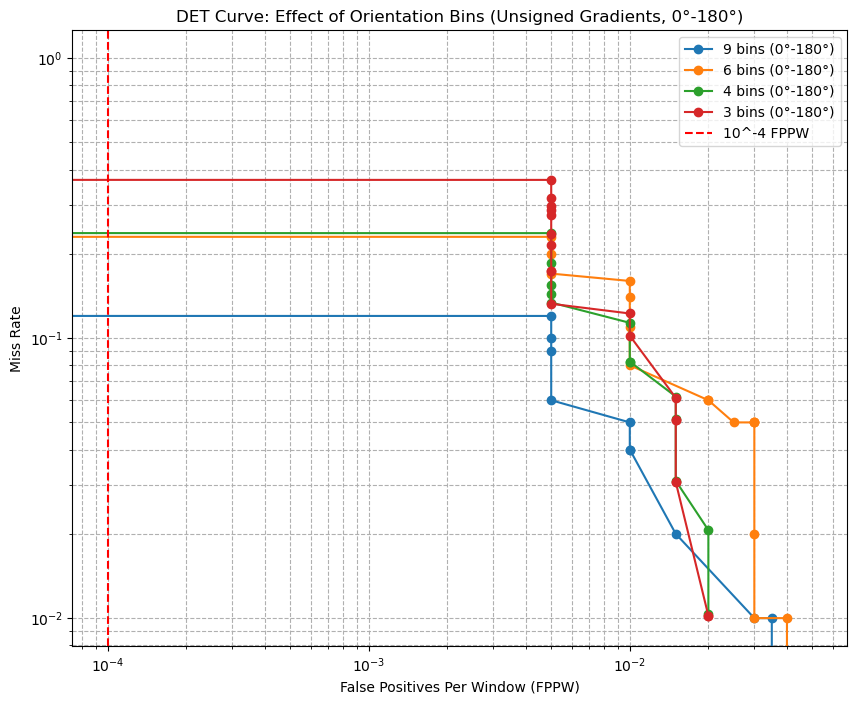

Ablation study completed. DET curves saved as 'det_curve_ablation_unsigned.png'.


In [15]:
# Define configurations for ablation study (unsigned gradients, 0°-180°)
configs = [
    {"orientations": 9, "label": "9 bins (0°-180°)"},
    {"orientations": 6, "label": "6 bins (0°-180°)"},
    {"orientations": 4, "label": "4 bins (0°-180°)"},
    {"orientations": 3, "label": "3 bins (0°-180°)"},
]

# Store DET curve data for all configurations
all_fppws = {}
all_miss_rates = {}

# Perform ablation study
for config in configs:
    print(f"\nTraining and evaluating with {config['label']}...")
    
    # Extract HOG features for training
    data = []
    for img in tqdm(train_images, desc=f"Extracting HOG features for training ({config['label']})"):
        # Verify image shape before HOG extraction
        if len(img.shape) != 2:
            raise ValueError(f"Expected 2D grayscale image, got shape {img.shape}")
        fd = hog(img, orientations=config['orientations'], pixels_per_cell=pixels_per_cell, 
                 cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
        data.append(fd)
    
    data = np.array(data)
    labels = np.array(train_labels)
    
    # Train SVM
    scaler = StandardScaler()
    trainData_scaled = scaler.fit_transform(data)
    model = LinearSVC(max_iter=1000, C=0.0001)
    model.fit(trainData_scaled, labels)
    print(f"SVM model trained for {config['label']}.")
    
    # Save model and scaler for this configuration
    joblib.dump(model, f'Others/hog_svm_model_{config["orientations"]}_unsigned.npy')
    joblib.dump(scaler, f'Others/hog_scaler_{config["orientations"]}_unsigned.npy')
    
    # Collect scores and predictions for DET curve
    all_scores = []
    all_labels = []
    total_windows_sum = 0
    for i in tqdm(range(len(test_images)), desc=f"Computing DET data ({config['label']})"):
        img = test_images[i]
        true_label = test_labels[i]
        # Unpack all four return values from detect_pedestrians
        detections, total_windows, positive_predictions, hog_image = detect_pedestrians(
            img, model, scaler, threshold=0.2, orientations=config['orientations']
        )
        total_windows_sum += total_windows
        for _, _, score, _, _ in detections:
            all_scores.append(score)
            all_labels.append(true_label)
    
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)
    
    # Compute DET curve
    thresholds = np.linspace(min(all_scores) if all_scores.size > 0 else -2, max(all_scores) if all_scores.size > 0 else 2, 50)
    fppws = []
    miss_rates = []
    for thresh in thresholds:
        y_pred = (all_scores > thresh).astype(int)
        miss_rates.append(1 - recall_score(all_labels, y_pred))
        false_positives = np.sum((all_labels == 0) & (y_pred == 1))
        fppws.append(false_positives / total_windows_sum if total_windows_sum > 0 else 0)
    
    all_fppws[config['label']] = fppws
    all_miss_rates[config['label']] = miss_rates

# Plot DET curves for all configurations
plt.figure(figsize=(10, 8))
for label in all_fppws.keys():
    plt.loglog(all_fppws[label], all_miss_rates[label], marker='o', label=label)

plt.xlabel('False Positives Per Window (FPPW)')
plt.ylabel('Miss Rate')
plt.title('DET Curve: Effect of Orientation Bins (Unsigned Gradients, 0°-180°)')
plt.grid(True, which="both", ls="--")
plt.axvline(x=1e-4, color='r', linestyle='--', label='10^-4 FPPW')
plt.legend()
plt.savefig('Others/det_curve_ablation_unsigned.png')
plt.show()

print("Ablation study completed. DET curves saved as 'det_curve_ablation_unsigned.png'.")

In [16]:
# Compute and print miss rates at FPPW ≈ 10^-4
print("\nMiss Rates at FPPW ≈ 10^-4:")
for label in all_fppws.keys():
    fppw_array = np.array(all_fppws[label])
    miss_rate_array = np.array(all_miss_rates[label])
    fppw_idx = np.argmin(np.abs(fppw_array - 1e-4))
    miss_rate = miss_rate_array[fppw_idx]
    print(f"  {label}: {miss_rate:.2f}")


Miss Rates at FPPW ≈ 10^-4:
  9 bins (0°-180°): 0.13
  6 bins (0°-180°): 0.23
  4 bins (0°-180°): 0.29
  3 bins (0°-180°): 0.41


## GUI for detection

In [ ]:
# Load the model and scaler
model = joblib.load('Others/hog_svm_model.npy')
scaler = joblib.load('Others/hog_scaler.npy')


# GUI Application
class PedestrianDetectorGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Pedestrian Detector")
        self.root.geometry("1500x600")  # Maintain current size
        self.root.configure(bg="#f0f0f0")

        # Variables
        self.image_path = tk.StringVar()
        self.image_tk = None
        self.detected_image_tk = None
        self.hog_image_tk = None

        # GUI Elements
        self.create_widgets()

    def create_widgets(self):
        # Main container frames for left, center, and right sides
        left_frame = tk.Frame(self.root, bg="#f0f0f0")
        left_frame.pack(side=tk.LEFT, padx=20, pady=20, fill=tk.BOTH, expand=True)

        center_frame = tk.Frame(self.root, bg="#f0f0f0")
        center_frame.pack(side=tk.LEFT, padx=20, pady=20, fill=tk.BOTH, expand=True)

        right_frame = tk.Frame(self.root, bg="#f0f0f0")
        right_frame.pack(side=tk.LEFT, padx=20, pady=20, fill=tk.BOTH, expand=True)

        # Left Side: Load Image Button and Input Image
        tk.Button(
            left_frame, 
            text="Load Image", 
            command=self.load_image, 
            bg="#4CAF50", fg="white", font=("Arial", 12, "bold"),
            relief=tk.RAISED, padx=10, pady=5
        ).pack(pady=10)

        tk.Label(left_frame, text="Input Image", font=("Arial", 14, "bold"), bg="#f0f0f0").pack(pady=5)
        self.image_frame = tk.Label(left_frame, bg="#ffffff", relief=tk.SUNKEN, borderwidth=2)
        self.image_frame.pack(pady=10, fill=tk.BOTH, expand=True)

        # Center Side: Detect Button and Detected Image
        self.detect_button = tk.Button(
            center_frame, 
            text="Detect Pedestrians", 
            command=self.detect_pedestrians_gui, 
            state=tk.DISABLED,
            bg="#2196F3", fg="white", font=("Arial", 12, "bold"),
            relief=tk.RAISED, padx=10, pady=5
        )
        self.detect_button.pack(pady=10)

        tk.Label(center_frame, text="Detected Image", font=("Arial", 14, "bold"), bg="#f0f0f0").pack(pady=5)
        self.detected_frame = tk.Label(center_frame, bg="#ffffff", relief=tk.SUNKEN, borderwidth=2)
        self.detected_frame.pack(pady=10, fill=tk.BOTH, expand=True)

        # Right Side: Placeholder for imaginary button and HOG Visualization
        tk.Button(
            right_frame, 
            text="",  # Empty text for imaginary button placeholder
            state=tk.DISABLED,  # Disabled to prevent interaction
            bg="#f0f0f0", fg="#f0f0f0",  # Match background to hide it
            font=("Arial", 12, "bold"),
            relief=tk.FLAT, padx=10, pady=5
        ).pack(pady=10)  # Placeholder for imaginary button

        tk.Label(right_frame, text="HOG Visualization", font=("Arial", 14, "bold"), bg="#f0f0f0").pack(pady=5)
        self.hog_frame = tk.Label(right_frame, bg="#ffffff", relief=tk.SUNKEN, borderwidth=2)
        self.hog_frame.pack(pady=10, fill=tk.BOTH, expand=True)

    def load_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
        if file_path:
            self.image_path.set(file_path)
            image = Image.open(file_path).convert('L')
            image = image.resize((300, 400), Image.Resampling.LANCZOS)
            self.image_tk = ImageTk.PhotoImage(image)
            self.image_frame.config(image=self.image_tk)
            self.image_frame.image = self.image_tk
            self.root.update_idletasks()
            self.detect_button.config(state=tk.NORMAL)

    def detect_pedestrians_gui(self):
        if not self.image_path.get():
            messagebox.showerror("Error", "Please load an image first!")
            return

        image = cv2.imread(self.image_path.get(), cv2.IMREAD_GRAYSCALE)
        if image is None:
            messagebox.showerror("Error", "Failed to load the image!")
            return

        # Detect pedestrians and get HOG visualization with fixed orientations=9
        detections, total_windows, positive_predictions, hog_image = detect_pedestrians(
            image, model, scaler, threshold=0.2, orientations=9
        )

        # Apply non-maximum suppression
        rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) if detections else np.array([])
        scores = np.array([score for (_, _, score, _, _) in detections]) if detections else np.array([])
        pick = non_max_suppression(rects, probs=scores, overlapThresh=0.3) if len(rects) > 0 else []

        # Prepare original image for visualization
        img_display = image.copy()
        if np.max(img_display) > np.min(img_display):
            img_display = (img_display - np.min(img_display)) / (np.max(img_display) - np.min(img_display)) * 255
        img_display = img_display.astype(np.uint8)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2BGR)

        # Draw rectangles on detected image
        detected_img = img_display.copy()
        for (xA, yA, xB, yB) in pick:
            cv2.rectangle(detected_img, (xA, yA), (xB, yB), (0, 255, 0), 2)

        # Prepare HOG image
        hog_image = cv2.resize(hog_image, (300, 400), interpolation=cv2.INTER_AREA)
        hog_image = cv2.cvtColor(hog_image, cv2.COLOR_GRAY2RGB)

        # Display images
        detected_image = Image.fromarray(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
        detected_image = detected_image.resize((300, 400), Image.Resampling.LANCZOS)
        self.detected_image_tk = ImageTk.PhotoImage(detected_image)
        self.detected_frame.config(image=self.detected_image_tk)
        self.detected_frame.image = self.detected_image_tk

        hog_image_pil = Image.fromarray(hog_image)
        self.hog_image_tk = ImageTk.PhotoImage(hog_image_pil)
        self.hog_frame.config(image=self.hog_image_tk)
        self.hog_frame.image = self.hog_image_tk

        messagebox.showinfo("Detection Result", f"Total windows checked: {total_windows}\nPositive predictions: {positive_predictions}")

if __name__ == "__main__":
    root = tk.Tk()
    app = PedestrianDetectorGUI(root)
    root.mainloop()

Total windows checked: 1
Positive predictions: 0 (0.00%)
High confidence detections: 0 (0.00%)
Positive prediction at (0, 0), Score: 2.5280
Detection:: Location -> (0, 0), Score -> 2.5280
Total windows checked: 1
Positive predictions: 1 (100.00%)
High confidence detections: 1 (100.00%)


## Appendix: Display image from training dataset

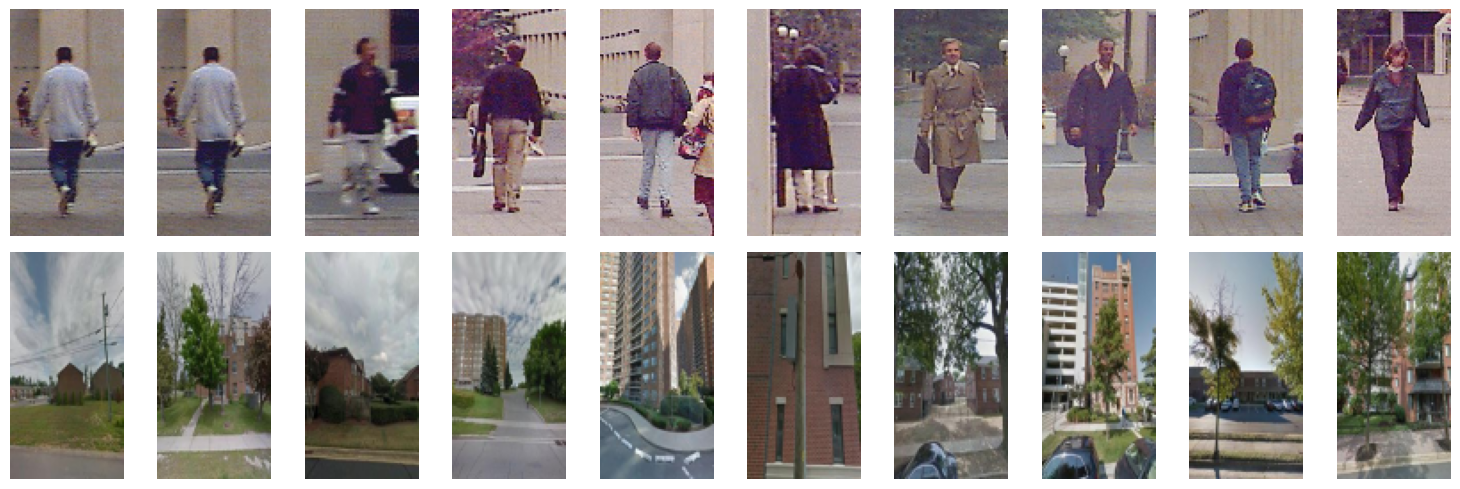

In [22]:


# Define directories containing positive and negative training images
positive_dir = r".\Others\positive images\train"  
negative_dir = r".\Others\negative images\train" 
output_file = "training_images_montage.png"

# Parameters
image_size = (64, 128) 
num_images_per_row = 10  # Number of images to display per row 

# Function to load and process images from a directory
def load_images_from_dir(directory, num_images):
    image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_files = image_files[:num_images]  # Take the first num_images
    images = []
    for file in image_files:
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        # Convert BGR to RGB (since cv2 loads in BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to match training size
        img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
        images.append(img)
    return images

# Load positive and negative images
positive_images = load_images_from_dir(positive_dir, num_images_per_row)
negative_images = load_images_from_dir(negative_dir, num_images_per_row)

# Ensure both rows have the same number of images for alignment
max_images = min(len(positive_images), len(negative_images), num_images_per_row)
positive_images = positive_images[:max_images]
negative_images = negative_images[:max_images]

# Create a figure with two rows of subplots
fig, axes = plt.subplots(2, max_images, figsize=(15, 5))  # 2 rows, max_images columns

# Display positive images in the first row
for ax, img in zip(axes[0], positive_images):
    ax.imshow(img)
    ax.axis('off')
axes[0, 0].set_ylabel("Positive Images", fontsize=12, fontweight='bold')

# Display negative images in the second row
for ax, img in zip(axes[1], negative_images):
    ax.imshow(img)
    ax.axis('off')
axes[1, 0].set_ylabel("Negative Images", fontsize=12, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
